# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
 
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Для проведения исследования доступны следующие данные:** 
- датасет с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- датасет с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- датасет с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- датасет с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**План проведения исследования:**
- изучим данные;
- проведём предобработку;
- выполним исследовательский и корреляционный анализ данных;
- создадим пайплайн, который поможет выбрать лучшую модель для прогноза вероятности снижения покупательской активности;
- выделим сегмент покупателей, проанализируем его и составим рекомендации по увеличению покупательской активности данной группы клиентов.

## Загрузка и чтение данных

### Подготовка к чтению данных

<font size="3"> Импортируем необходимые библиотеки:

In [133]:
pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [134]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [135]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [136]:
! pip install scikit-learn==1.3.0. -q

In [137]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

import shap
import phik
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

<font size="3">
Выберем параметры отображения данных и визуализаций:

In [138]:
sns.set_theme(style="darkgrid", palette="icefire")
sns.set(rc = {'figure.figsize' : (12, 6)})

pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format

### Чтение данных

<font size="3">

- **Датасет `market_file`**

<font size="3"> Считаем данные о поведении покупателя на сайте, о коммуникациях с покупателем, его продуктовом поведении и сохраним в переменную `market`:

In [139]:
market = pd.read_csv('/Users/kasper/Desktop/Jupyter/data/Supervised learning/market_file.csv', sep = ',')

<font size="3"> Выведем первые 20 строчек датафрейма `market` на экран:

In [140]:
market.head(20)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0   215348                 Снизилась     премиум                 да   
1   215349                 Снизилась     премиум                 да   
2   215350                 Снизилась   стандартт                нет   
3   215351                 Снизилась   стандартт                 да   
4   215352                 Снизилась   стандартт                нет   
5   215353                 Снизилась   стандартт                 да   
6   215354                 Снизилась   стандартт                 да   
7   215355                 Снизилась   стандартт                нет   
8   215356                 Снизилась   стандартт                 да   
9   215357                 Снизилась   стандартт                 да   
10  215358                 Снизилась   стандартт                 да   
11  215359                 Снизилась    стандарт                 да   
12  215360                 Снизилась     премиум                 да   
13  215361                 Снизилась    стандарт                 да   
14  215362                 Снизилась     премиум                 да   
15  215363                 Снизилась    стандарт                нет   
16  215364                 Снизилась     премиум                 да   
17  215365                 Снизилась    стандарт                 да   
18  215366                 Снизилась    стандарт                нет   
19  215367                 Снизилась     премиум                 да   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                3.400                     5           121              0.000   
1                4.400                     4           819              0.750   
2                4.900                     3           539              0.140   
3                3.200                     5           896              0.990   
4                5.100                     3          1064              0.940   
5                3.300                     4           762              0.260   
6                5.100                     3           431              0.230   
7                4.700                     4           284              0.170   
8                4.200                     4           192              0.140   
9                3.900                     5           154              0.000   
10               4.700                     4           450              0.130   
11               4.600                     5           110              0.000   
12               3.900                     3           623              0.350   
13               5.100                     4           199              0.230   
14               4.200                     4           438              0.740   
15               4.900                     4           923              0.290   
16               4.300                     4           708              0.980   
17               3.900                     4           167              0.950   
18               3.800                     3           209              0.220   
19               4.200                     4           581              0.400   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                 Товары для детей                                    6   
1                 Товары для детей                                    4   
2                Домашний текстиль                                    5   
3                 Товары для детей                                    5   
4                 Товары для детей                                    3   
5                Домашний текстиль                                    4   
6            Косметика и аксесуары                                    2   
7                 Товары для детей                                    5   
8            Косметика и аксесуары                                    2   
9   Техника для красоты и здоровья                              

<font size="3">

- **Датасет `market_money`**

<font size="3"> Считаем данные о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом) и сохраним в переменную `revenue`:

In [141]:
revenue = pd.read_csv('/Users/kasper/Desktop/Jupyter/data/Supervised learning/market_money.csv', sep = ',')

<font size="3"> Выведем первые 20 строчек датафрейма `revenue` на экран:

In [142]:
revenue.head(20)

id               Период   Выручка
0   215348  препредыдущий_месяц     0.000
1   215348        текущий_месяц 3,293.100
2   215348     предыдущий_месяц     0.000
3   215349  препредыдущий_месяц 4,472.000
4   215349        текущий_месяц 4,971.600
5   215349     предыдущий_месяц 5,216.000
6   215350  препредыдущий_месяц 4,826.000
7   215350        текущий_месяц 5,058.400
8   215350     предыдущий_месяц 5,457.500
9   215351        текущий_месяц 6,610.400
10  215351     предыдущий_месяц 6,158.000
11  215351  препредыдущий_месяц 4,793.000
12  215352     предыдущий_месяц 5,807.500
13  215352  препредыдущий_месяц 4,594.000
14  215352        текущий_месяц 5,872.500
15  215353     предыдущий_месяц 4,738.500
16  215353  препредыдущий_месяц 5,124.000
17  215353        текущий_месяц 5,388.500
18  215354     предыдущий_месяц 5,685.000
19  215354        текущий_месяц 5,869.600

<font size="3">

- **Датасет `market_time`**

<font size="3"> Считаем данные о времени (в минутах), которое покупатель провёл на сайте в течение периода и сохраним в переменную `time`:

In [143]:
time = pd.read_csv('/Users/kasper/Desktop/Jupyter/data/Supervised learning/market_time.csv', sep = ',')

<font size="3"> Выведем первые 20 строчек датафрейма `time` на экран:

In [144]:
time.head(20)

id            Период  минут
0   215348     текущий_месяц     14
1   215348  предыдцщий_месяц     13
2   215349     текущий_месяц     10
3   215349  предыдцщий_месяц     12
4   215350     текущий_месяц     13
5   215350  предыдцщий_месяц      8
6   215351     текущий_месяц     13
7   215351  предыдцщий_месяц     11
8   215352     текущий_месяц     11
9   215352  предыдцщий_месяц      8
10  215353  предыдцщий_месяц     10
11  215353     текущий_месяц     10
12  215354  предыдцщий_месяц     11
13  215354     текущий_месяц     12
14  215355  предыдцщий_месяц     12
15  215355     текущий_месяц     10
16  215356  предыдцщий_месяц      6
17  215356     текущий_месяц      7
18  215357  предыдцщий_месяц     12
19  215357     текущий_месяц      6

<font size="3">

- **Датасет `money`**

<font size="3"> Считаем данные о среднемесячной прибыли покупателя за последние 3 месяца (какую прибыль получает магазин от продаж каждому покупателю) и сохраним в переменную `profit`:

In [145]:
profit = pd.read_csv('/Users/kasper/Desktop/Jupyter/data/Supervised learning/money.csv', sep = ';', decimal = ',')

<font size="3"> Выведем первые 20 строчек датафрейма `profit` на экран:

In [146]:
profit.head(20)

id  Прибыль
0   215348    0.980
1   215349    4.160
2   215350    3.130
3   215351    4.870
4   215352    4.210
5   215353    3.950
6   215354    3.620
7   215355    5.260
8   215356    4.930
9   215357    4.660
10  215358    3.060
11  215359    5.080
12  215360    4.550
13  215361    4.030
14  215362    3.490
15  215363    1.830
16  215364    2.670
17  215365    3.650
18  215366    2.950
19  215367    3.030

### Изучение датафреймов

<font size="3">
    
Изучим структуру и полноту полученных датафреймов

- **Датафрейм `market`**

In [147]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

<Axes: >

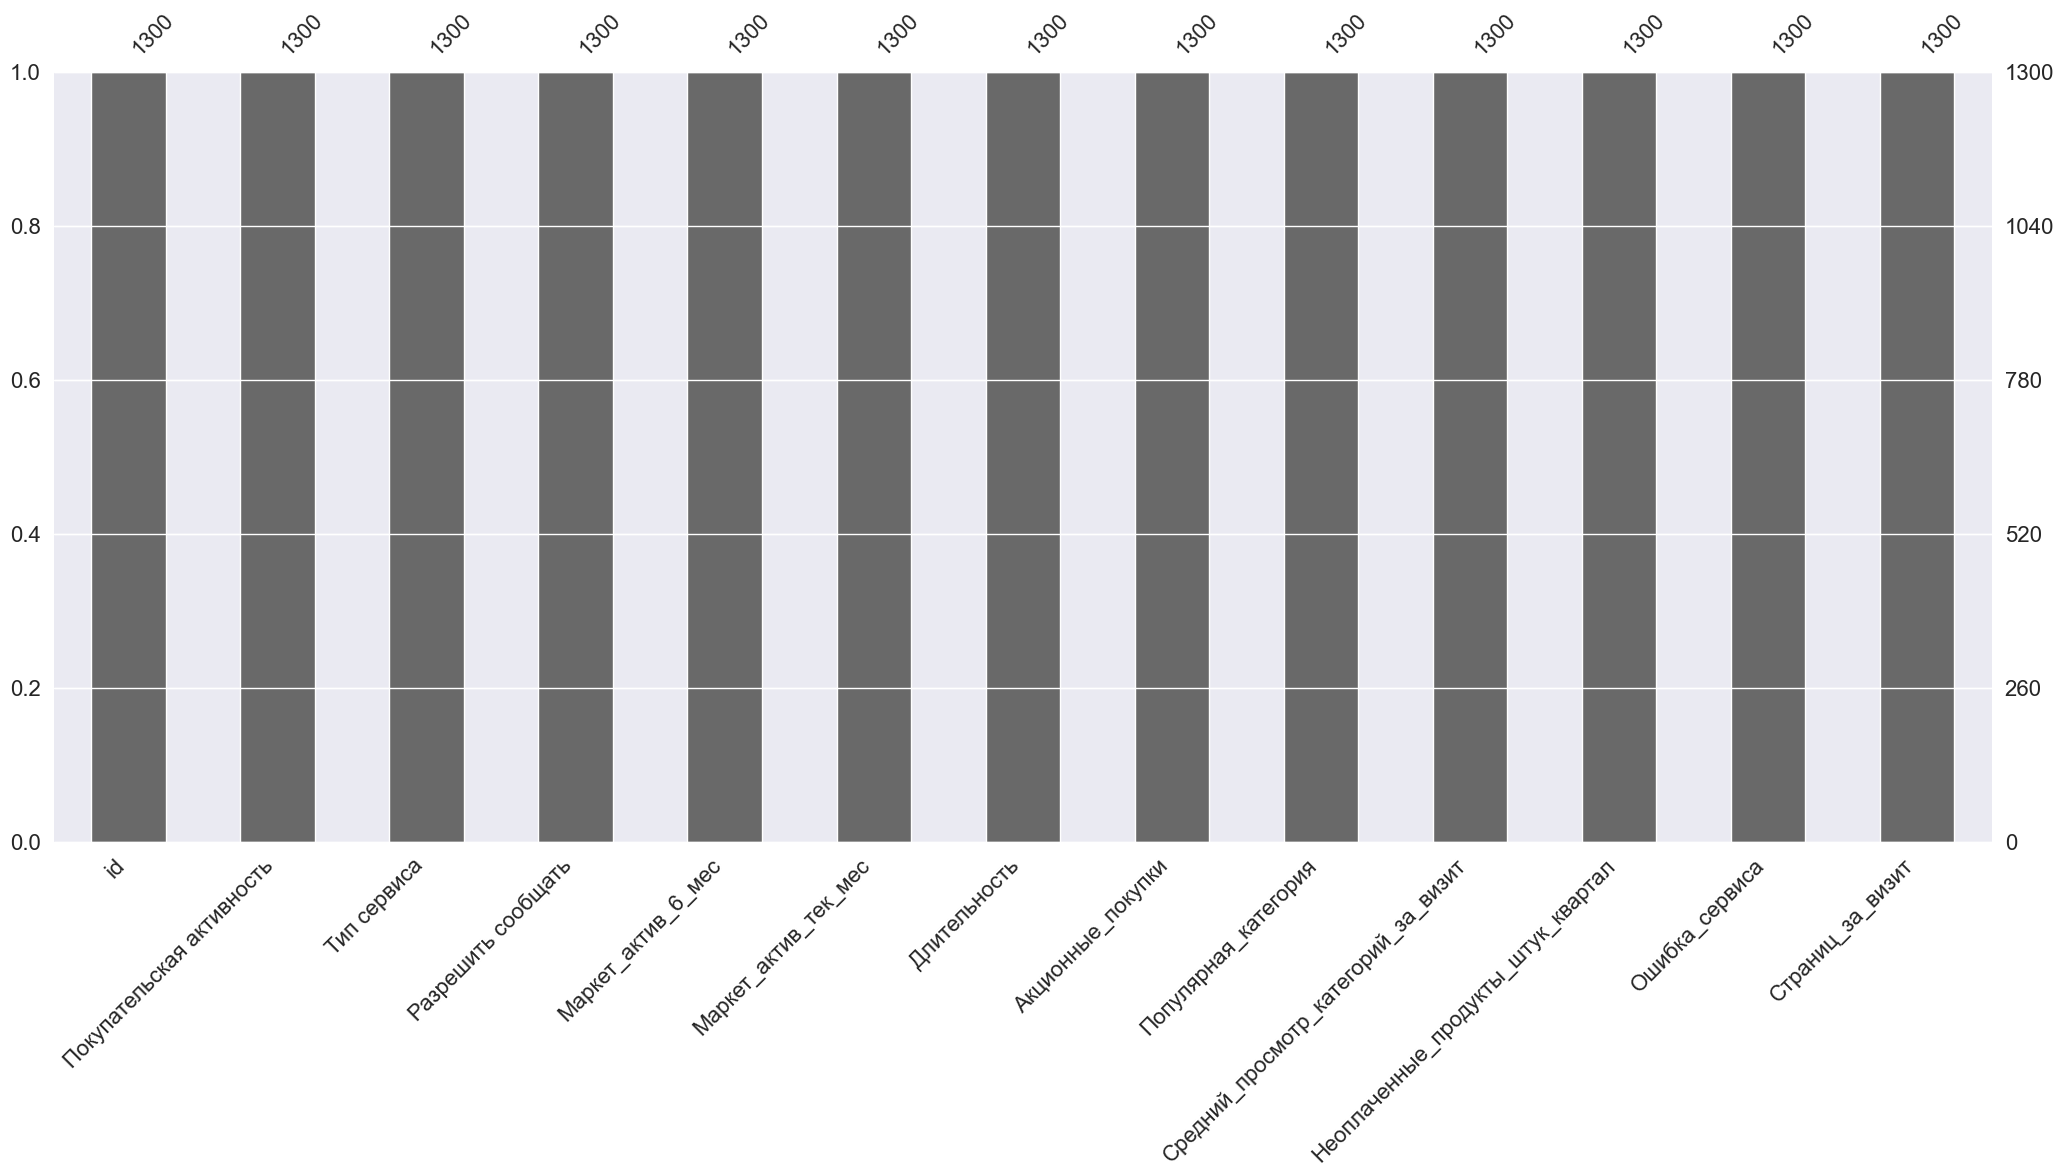

In [148]:
msno.bar(market)

<font size="3">

- **Датафрейм `revenue`**

In [149]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


<Axes: >

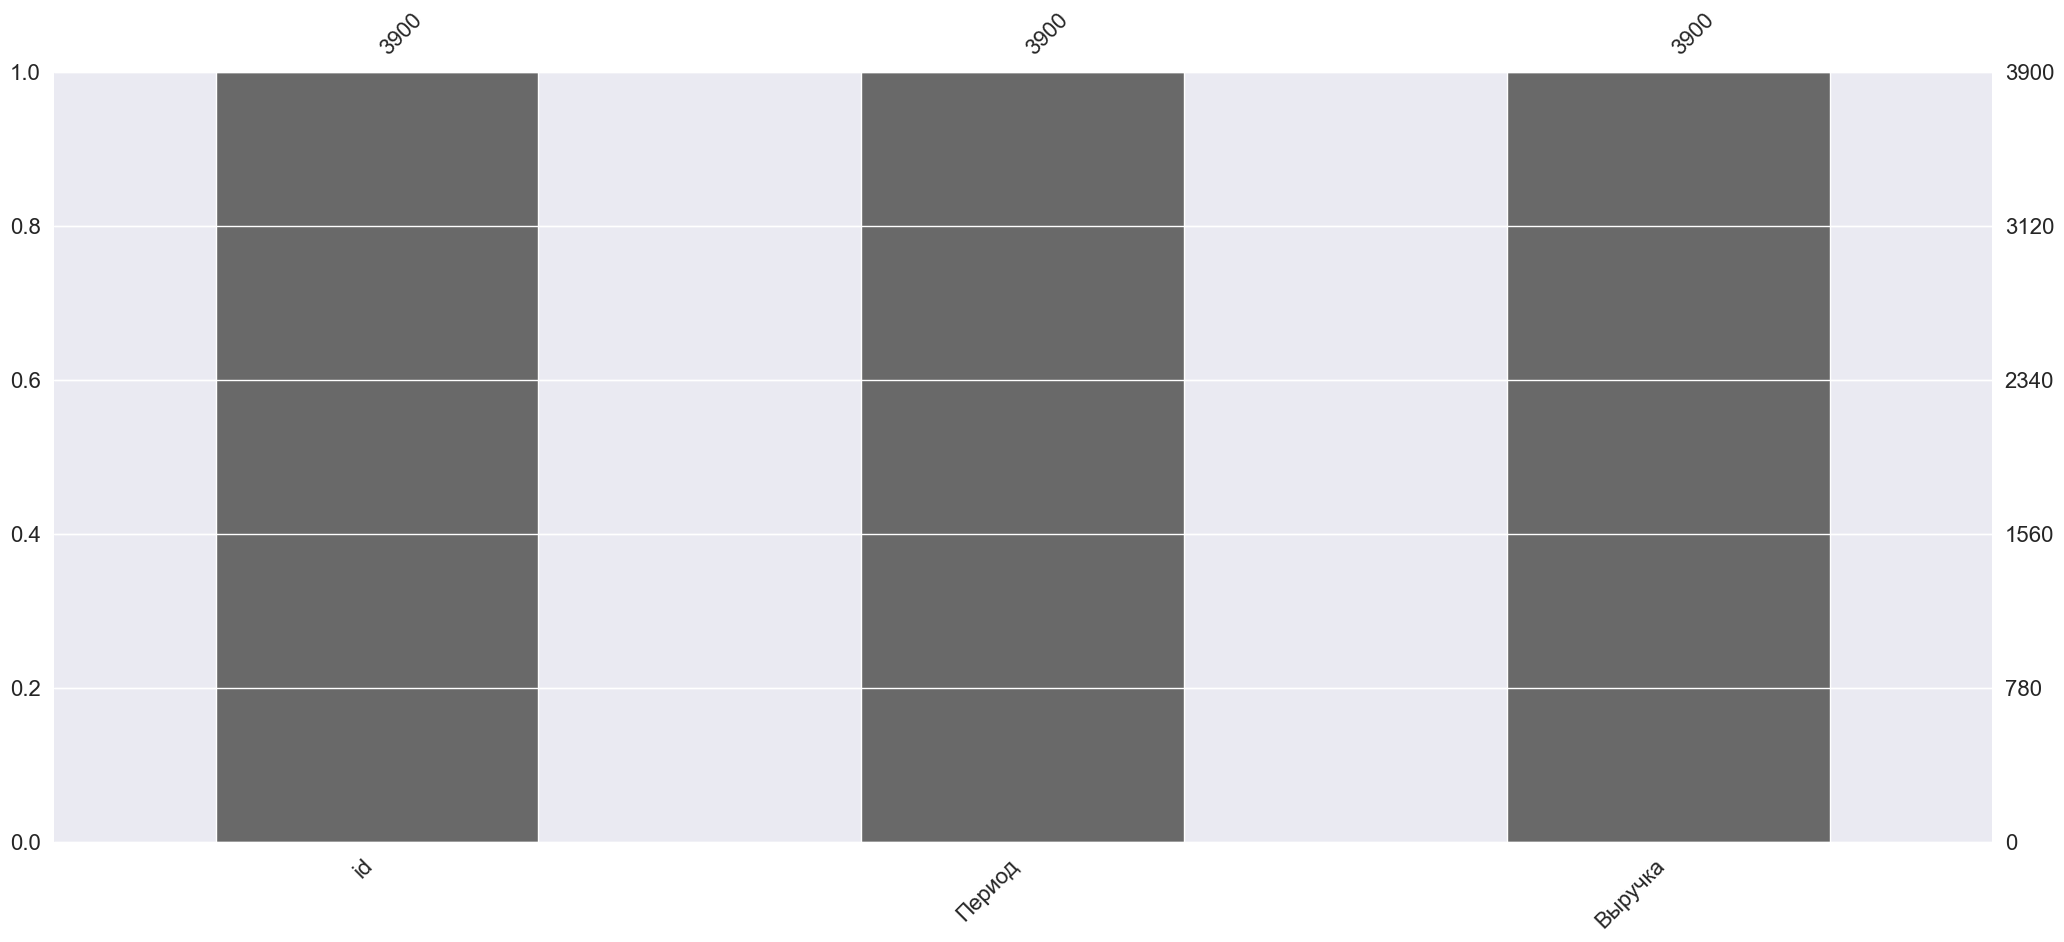

In [150]:
msno.bar(revenue)

<font size="3">

- **Датафрейм `time`**

In [151]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


<Axes: >

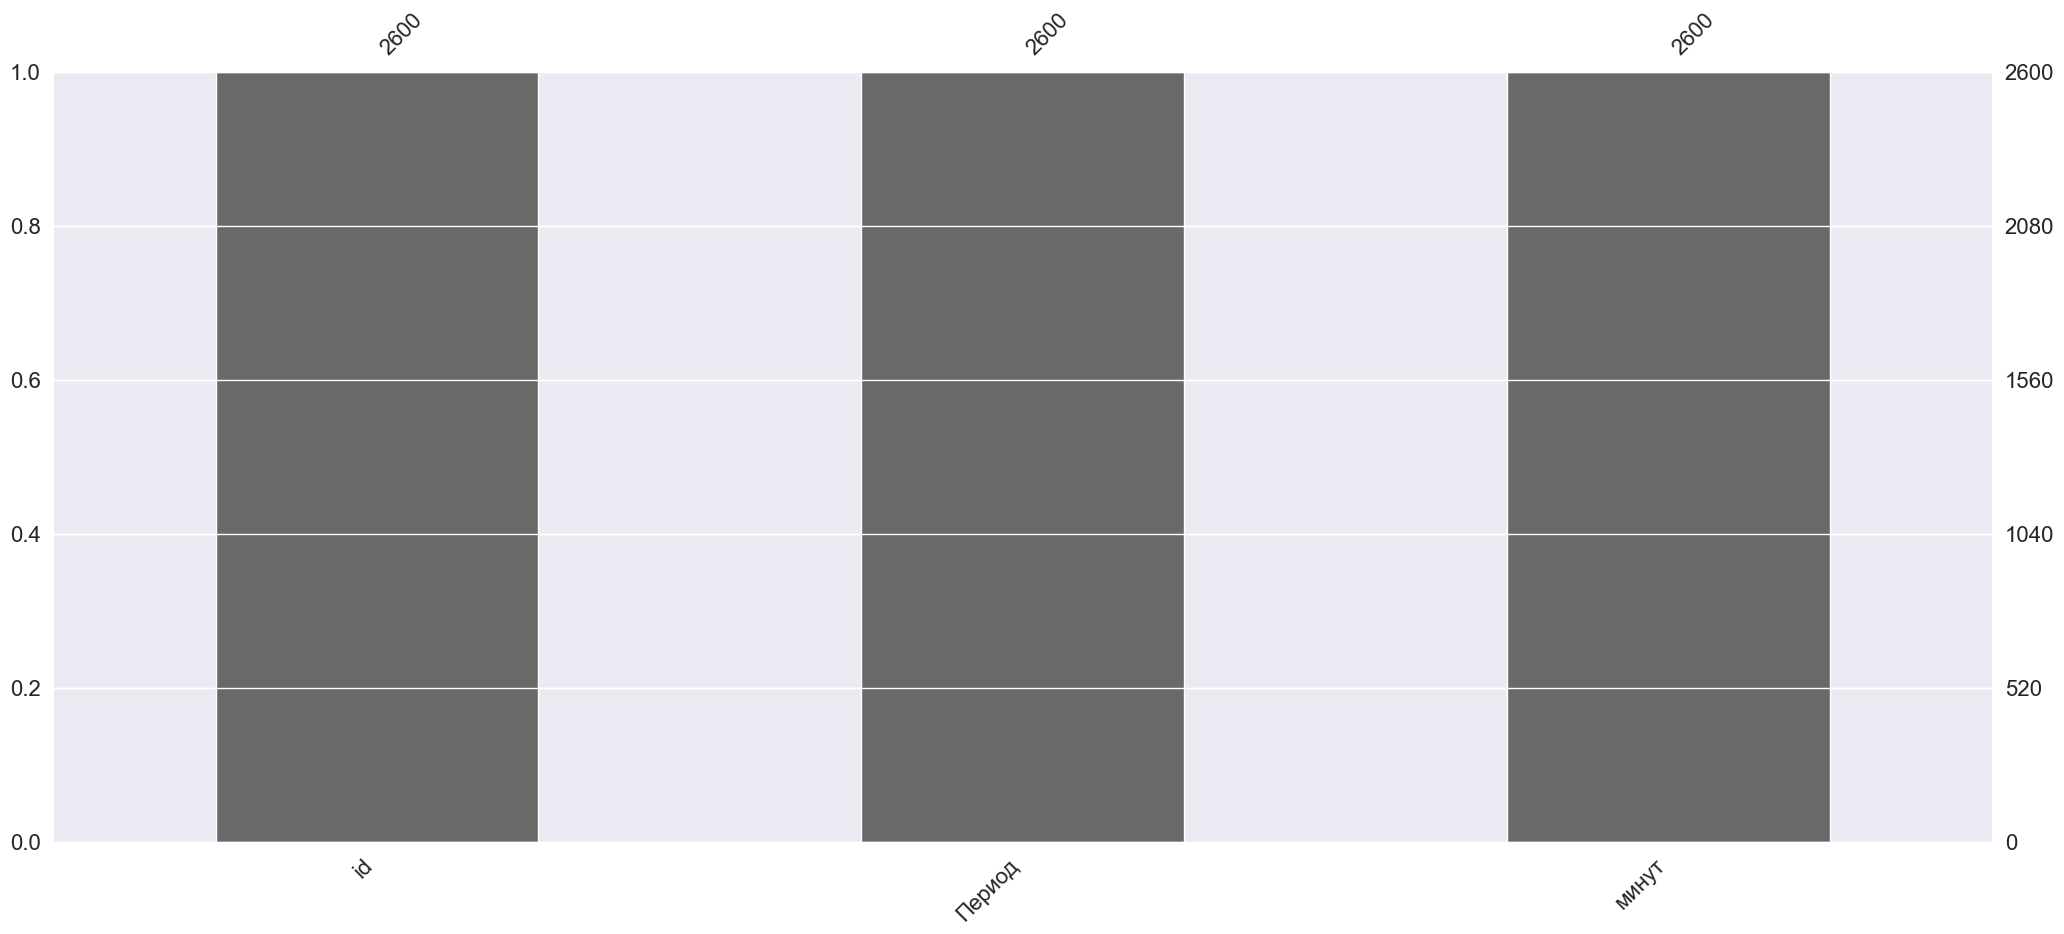

In [152]:
msno.bar(time)

<font size="3">

- **Датафрейм `profit`**

In [153]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<Axes: >

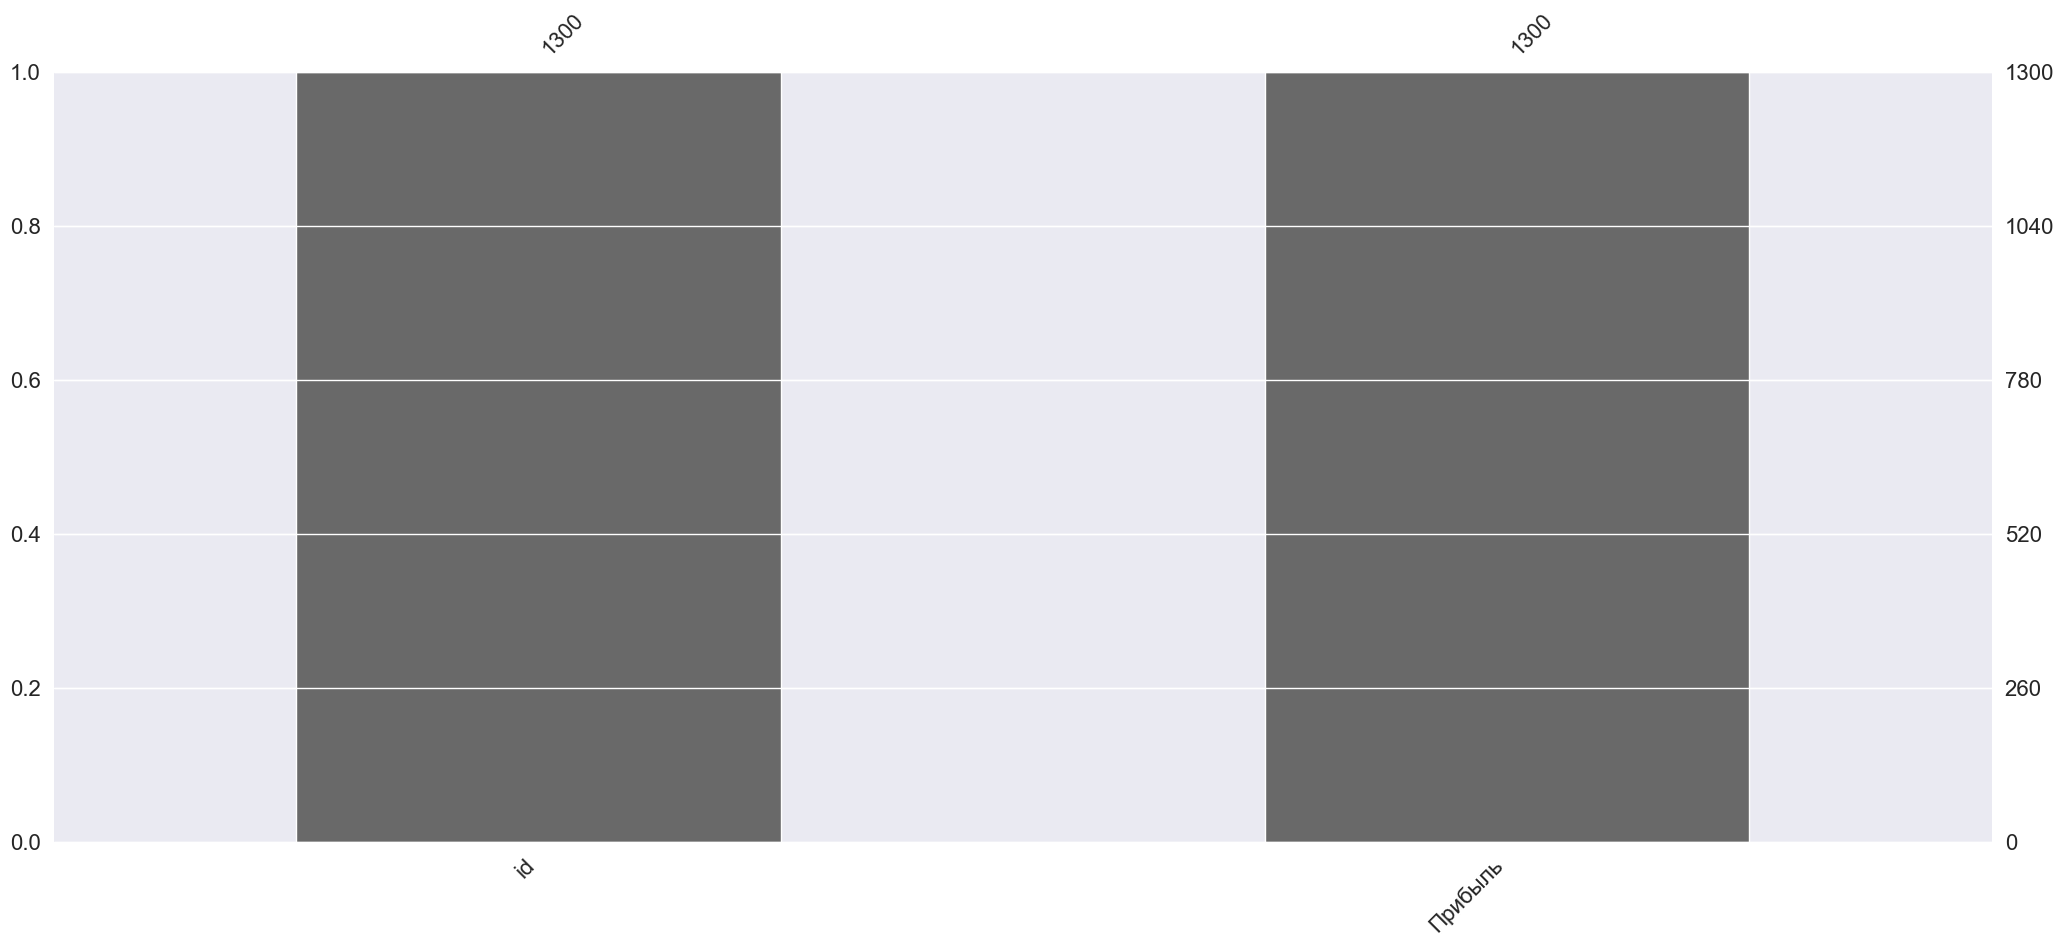

In [154]:
msno.bar(profit)

<font size="3">
    
**Вывод**

Полученные датафреймы содержат следующие данные:

- **датафрейм `market`:**
  * `id` — номер покупателя в корпоративной базе данных;
  * `Покупательская активность` — рассчитанный класс покупательской активности - целевой признак исследования;
  * `Тип сервиса` — уровень сервиса;
  * `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре;
  * `Маркет_актив_6_мес` — cреднемесячное значение маркетинговых коммуникаций компании c покупателем за последние 6 месяцев;
  * `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце;
  * `Длительность` — количество дней с момента регистрации покупателя на сайте;
  * `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
  * `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев;
  * `Средний_просмотр_категорий_за_визит` — среднее количество просмотренных категорий товаров за визит в течение последнего месяца;
  * `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца;
  * `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта;
  * `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

---

- **датафрейм `revenue`:**
  - `id` — номер покупателя в корпоративной базе данных;
  - `Период` — название периода, во время которого зафиксирована выручка;
  - `Выручка` — сумма выручки за период.
  
---

- **датафрейм `time`:**
  * `id` - номер покупателя в корпоративной базе данных;
  * `Период` — название периода, во время которого зафиксировано общее время;
  * `минут` — значение времени, проведённого на сайте, в минутах.

---

- **датафрейм `profit`:**
  * `id` - номер покупателя в корпоративной базе данных;
  * `Прибыль` — значение прибыли.

Предварительно можно утверждать, что данных достаточно для проведения анализа. В датасетах отсутствуют пропущенные значения.

При этом столбцы датафреймов именованы некорректно, стоит подробнее изучить тип имеющихся данных, а также в данных могут присутствовать дубликаты.

Необходима предобработка данных.  

---

## Предобработка данных

### Именование столбцов

<font size="3">
    
- **датафрейм `market`:**

Столбцы в датафрейме `market` именованы некорректно, переименуем:

In [155]:
market = market.rename(columns=lambda x: x.lower().replace(" ", "_"))

<font size="3">
Проверим результат переименования:

In [156]:
market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

<font size="3">
    
- **датафрейм `revenue`:**

Переименуем столбцы:

In [157]:
revenue = revenue.rename(columns=lambda x: x.lower())

<font size="3">
Проверим результат переименования:

In [158]:
revenue.columns

Index(['id', 'период', 'выручка'], dtype='object')

<font size="3">
    
- **датафрейм `time`:**

Переименуем столбцы:

In [159]:
time = time.rename(columns=lambda x: x.lower())

<font size="3">
Проверим результат переименования:

In [160]:
time.columns

Index(['id', 'период', 'минут'], dtype='object')

<font size="3">
    
- **датафрейм `profit`:**

Переименуем столбцы:

In [161]:
profit = profit.rename(columns=lambda x: x.lower())

<font size="3">
Проверим результат переименования:

In [162]:
profit.columns

Index(['id', 'прибыль'], dtype='object')

<font size="3">

**Вывод**

Столбцы датафреймов именованы корректно с соблюдением стандартов.

---

### Тип данных

<font size="3">
    
Убедимся, что в датафреймах корретный тип данных.
    
- **датафрейм `market`:**

In [163]:
market.dtypes

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

<font size="3"> Для удобства бинаризируем целевой признак `покупательская_активность`:

In [164]:
market['покупательская_активность'] = [1 if i == 'Снизилась' else 0 for i in market['покупательская_активность']]

<font size="3"> Проверим результат:

In [165]:
market['покупательская_активность'].value_counts()

0    802
1    498
Name: покупательская_активность, dtype: int64

<font size="3">
    
- **датафрейм `revenue`:**

In [166]:
revenue.dtypes

id           int64
период      object
выручка    float64
dtype: object

<font size="3">
    
- **датафрейм `time`:**

In [167]:
time.dtypes

id         int64
период    object
минут      int64
dtype: object

<font size="3">
    
- **датафрейм `profit`:**

In [168]:
profit.dtypes

id           int64
прибыль    float64
dtype: object

<font size="3">

**Вывод**

Все столбцы в датафреймах содержат корректный тип данных: количественные столбцы имеют тип `float64` и `int64`, категориальные - тип `object`.

---

### Проверка пропусков

<font size="3">
    
Гистограммы `msno` показали отсутствие пропущенных значений, данные в датафреймах представлены полностью, дополнительная проверка пропусков не требуется.

---

### Проверка явных дубликатов

<font size="3">
    
Проверим наличие явных дубликатов в датафреймах.

- **датафрейм `market`:**

In [169]:
market.duplicated().sum()

0

<font size="3">
    
Явные дубликаты отсутствуют.

<font size="3">
    
- **датафрейм `revenue`:**

In [170]:
revenue.duplicated().sum()

0

<font size="3">
    
Явные дубликаты отсутствуют.

<font size="3">
    
- **датафрейм `time`:**

In [171]:
time.duplicated().sum()

0

<font size="3">
    
Явные дубликаты отсутствуют.

<font size="3">
    
- **датафрейм `profit`:**

In [172]:
profit.duplicated().sum()

0

<font size="3">
    
Явные дубликаты отсутствуют.

---

### Проверка неявных дубликатов

<font size="3">
    
Проверим категориальные столбцы датафреймов на наличие неявных дубликатов.

<font size="3">

- **датафрейм `market`**
    
Столбец `тип_сервиса`:

In [173]:
market['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

<font size="3"> Выявлены неявные дубликаты в категории типа сервиса, заменим "стандартт" на "стандарт":

In [174]:
market['тип_сервиса'] = market['тип_сервиса'].replace(['стандартт'], 'стандарт', regex=True)

<font size="3"> Проверим результат:

In [175]:
market['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

<font size="3"> 10 значений с некорректным наименованием перенесены в категорию "стандарт", неявные дубликаты устранены.

---
<font size="3">Столбец `разрешить_сообщать`:

In [176]:
market['разрешить_сообщать'].value_counts()

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют

---
<font size="3">Столбец `популярная_категория`:

In [177]:
market['популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют

<font size="3">
    
- **датафрейм `revenue`**
    
Столбец `период`:

In [178]:
revenue['период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

<font size="3"> Переименуем значение "предпредыдущий_месяц" в "позапрошлый_месяц" для удобства.

In [179]:
revenue['период'] = revenue['период'].replace(
    ['препредыдущий_месяц'], 
    'позапрошлый_месяц', 
    regex=True
)

<font size="3"> Проверим результат:

In [180]:
revenue['период'].value_counts()

позапрошлый_месяц    1300
текущий_месяц        1300
предыдущий_месяц     1300
Name: период, dtype: int64

<font size="3"> Категории именованы корректно, неявные дубликаты отсутствуют

<font size="3">
    
- **датафрейм `time`**
    
Столбец `период`:

In [181]:
time['период'].value_counts()

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64

<font size="3"> Переименуем значение "предыдцщий_месяц" в "предыдущий_месяц".

In [182]:
time['период'] = time['период'].replace(
    ['предыдцщий_месяц'], 
    'предыдущий_месяц', 
    regex=True
)

<font size="3"> Проверим результат:

In [183]:
time['период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

<font size="3"> Категории именованы корректно, неявные дубликаты отсутствуют

---
<font size="3">

**Вывод**

Для корректного проведения исследования выполнена предобработка данных:

- Проверены типы данных;
- Проверены пропуски в датафреймах;
- Изучены и обработаны дубликаты в датафреймах, в том числе и неявные

---

## Исследовательский анализ данных

<font size="3">Проведём анализ всех признаков датафреймов.

### Количественные признаки


<font size="3"> Напишем функцию `visuals`, которая построит гистограмму распределения, коробчатую диаграмму и выведет метод `describe()`:

In [184]:
def visuals(df, cat):
    display(df[cat].describe())
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    df[cat].plot(kind='hist', bins=20, ax=axes[0])
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')
    
    df[cat].plot(kind='box', ax=axes[1], rot=0)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

<font size="3">
    
- **датафрейм market**
    
Изучим количественные признаки датафрейма `market`.

<font size="3">
    
1. Признак **маркет\_актив_ 6\_мес**

count   1,300.000
mean        4.254
std         1.015
min         0.900
25%         3.700
50%         4.200
75%         4.900
max         6.600
Name: маркет_актив_6_мес, dtype: float64

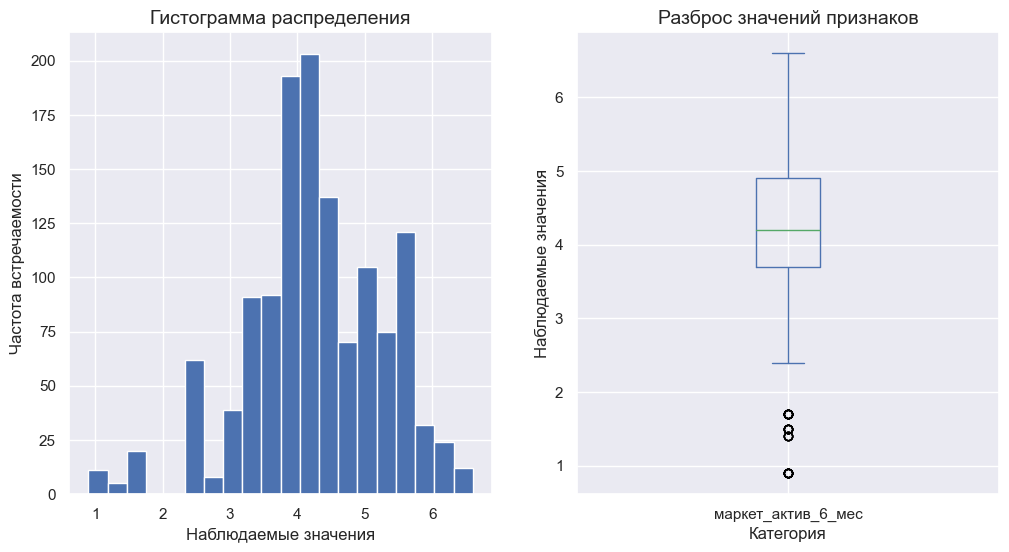

In [185]:
visuals(market, 'маркет_актив_6_мес')

<font size="3">
    
**Вывод**

Признак `маркет_актив_6_мес` отображает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 3.5 до 5 со средним значением 4.2.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
    
2. Признак **маркет_актив_тек_мес**

count   1,300.000
mean        4.012
std         0.697
min         3.000
25%         4.000
50%         4.000
75%         4.000
max         5.000
Name: маркет_актив_тек_мес, dtype: float64

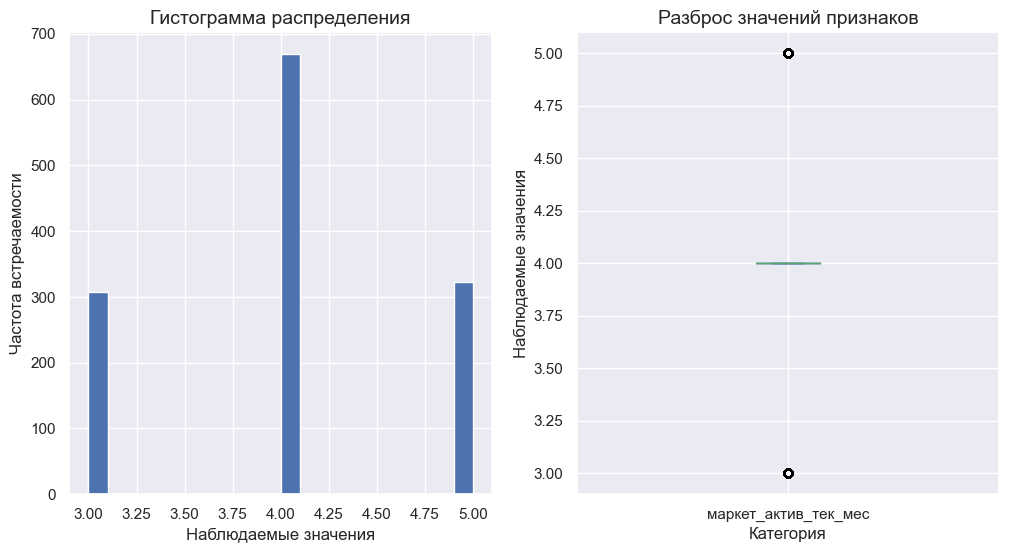

In [186]:
visuals(market, 'маркет_актив_тек_мес')

<font size="3">
    
**Вывод**

Признак `маркет_актив_тек_мес` отображает количество маркетинговых коммуникаций в текущем месяце. 
    
Признак представлен фиксированным набором значений: 3, 4 и 5. Наибольшее количество наблюдений имеет значение 4.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
    
3. Признак **длительность**

count   1,300.000
mean      601.898
std       249.856
min       110.000
25%       405.500
50%       606.000
75%       806.000
max     1,079.000
Name: длительность, dtype: float64

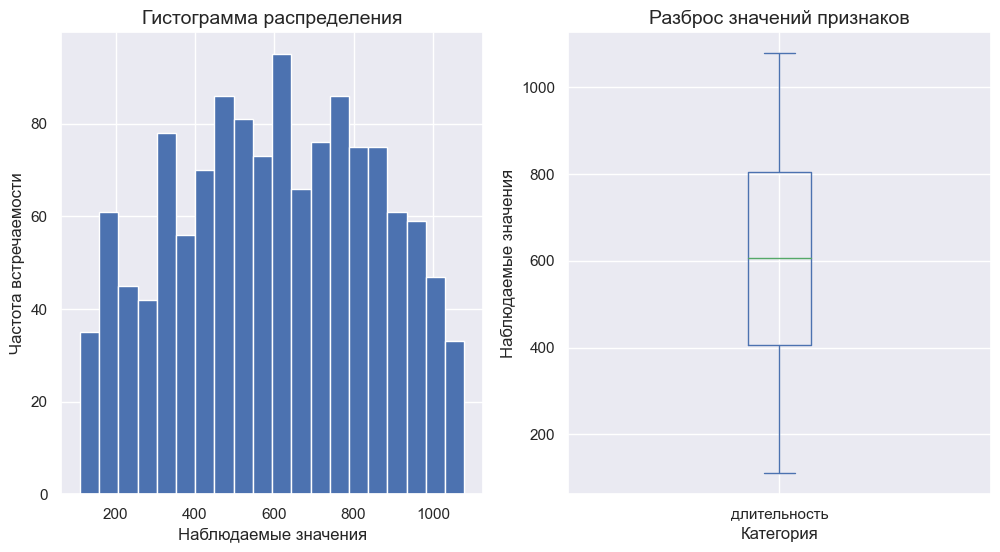

In [187]:
visuals(market, 'длительность')

<font size="3">
    
**Вывод**

Признак `длительность` показывает, сколько дней прошло с момента регистрации покупателя на сайте. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 400 до 800 дней со средним значением в 602 дня.

Выбросы и аномалии отсутствуют.

<font size="3">
    
4. Признак **акционные_покупки**

count   1,300.000
mean        0.320
std         0.250
min         0.000
25%         0.170
50%         0.240
75%         0.300
max         0.990
Name: акционные_покупки, dtype: float64

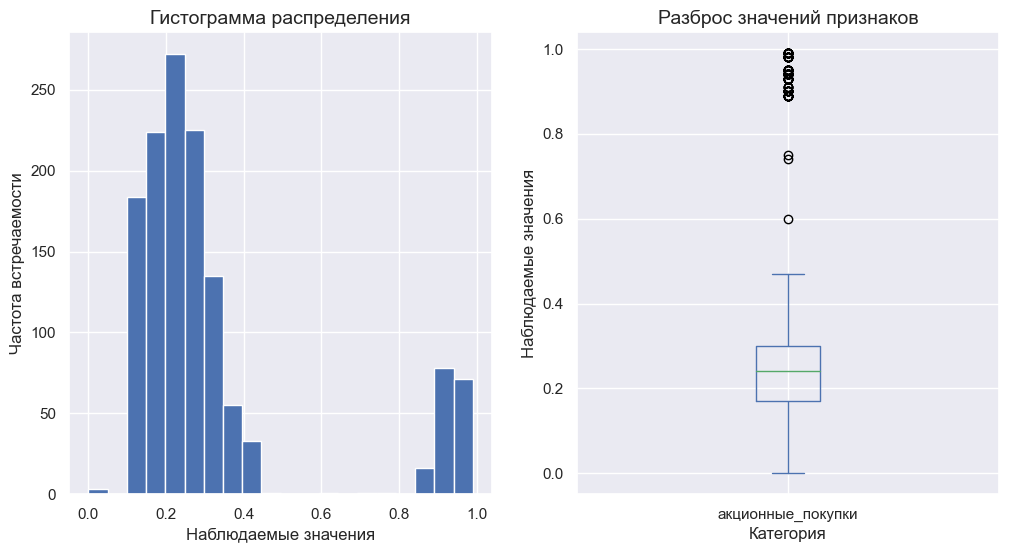

In [188]:
visuals(market, 'акционные_покупки')

<font size="3">
    
**Вывод**

Признак `акционные_покупки` отображает среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев. 
    
Распределение признака асимметрично вправо, большинство значений располагается в промежутке от 0.1 до 0.3.
    
В выборке есть пользователи, которые не совершали покупок по акции, а также клиенты, у которых доля акционных покупок составляла практически 100% от общего числа покупок.

Выбросы и аномалии отсутствуют.

<font size="3">
    
5. Признак **средний_просмотр_категорий_за_визит**

count   1,300.000
mean        3.270
std         1.355
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         6.000
Name: средний_просмотр_категорий_за_визит, dtype: float64

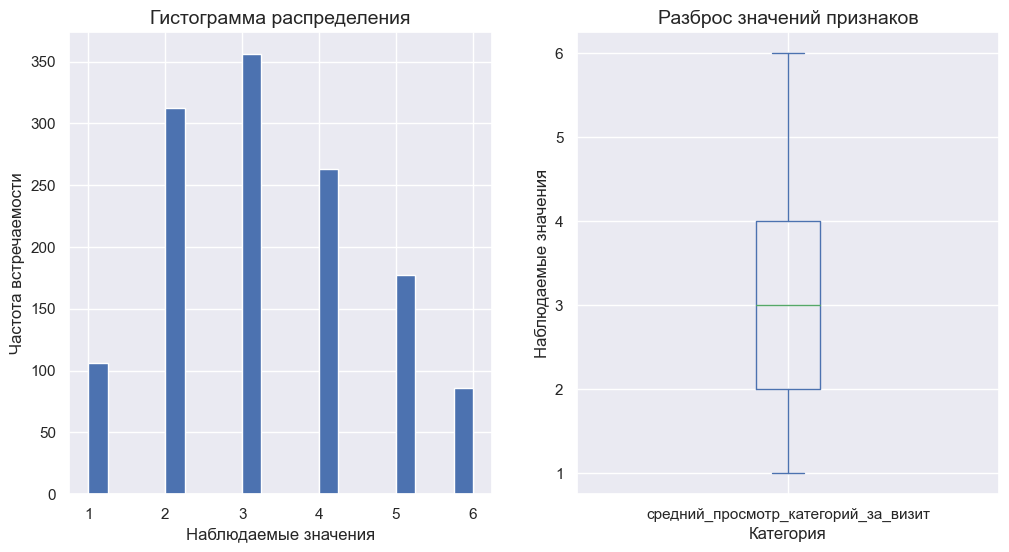

In [189]:
visuals(market, 'средний_просмотр_категорий_за_визит')

<font size="3">
    
**Вывод**

Признак `средний_просмотр_категорий_за_визит` показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 2 до 4 категорий со средним значением 3.3.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
    
6. Признак **неоплаченные_продукты_штук_квартал**

count   1,300.000
mean        2.840
std         1.971
min         0.000
25%         1.000
50%         3.000
75%         4.000
max        10.000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

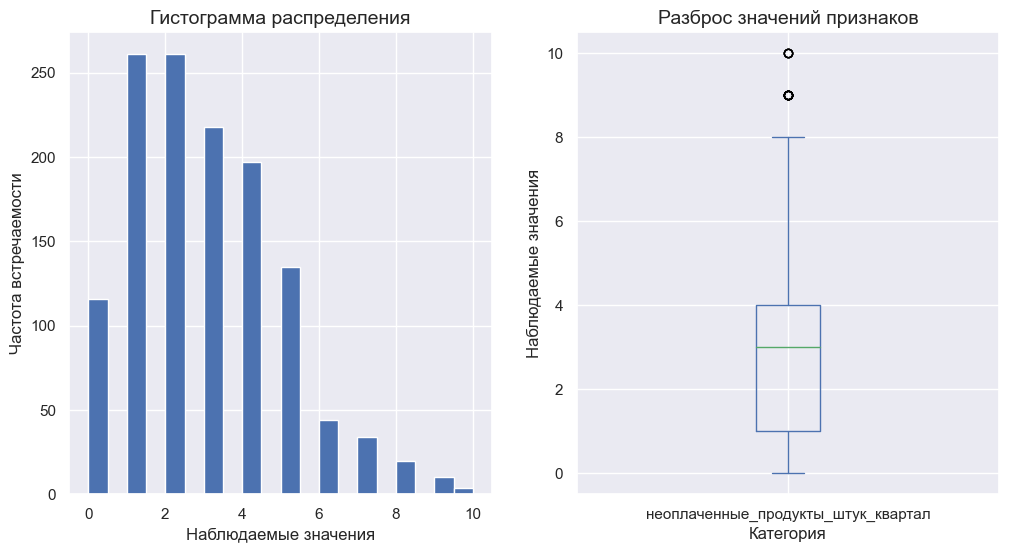

In [190]:
visuals(market, 'неоплаченные_продукты_штук_квартал')

<font size="3">
    
**Вывод**

Признак `неоплаченные_продукты_штук_квартал` показывает общее число неоплаченных товаров в корзине за последние 3 месяца. 
    
Распределение признака имеет положительную ассиметрию, большинство значений располагается в промежутке от 1 до 4 товаров.
    
Выбросы и аномалии отсутствуют.

<font size="3">
    
7. Признак **ошибка_сервиса**

count   1,300.000
mean        4.185
std         1.955
min         0.000
25%         3.000
50%         4.000
75%         6.000
max         9.000
Name: ошибка_сервиса, dtype: float64

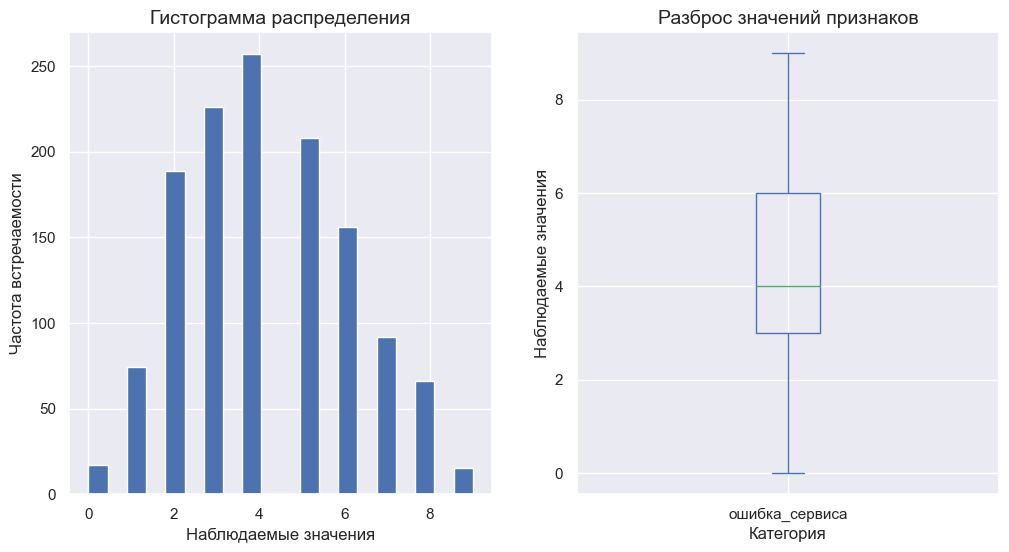

In [191]:
visuals(market, 'ошибка_сервиса')

<font size="3">
    
**Вывод**

Признак `ошибка_сервиса` показывает число сбоев, которые коснулись покупателя во время посещения сайта. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 3 до 6 сбоев со средним значением 4.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
    
8. Признак **cтраниц_за_визит**

count   1,300.000
mean        8.177
std         3.978
min         1.000
25%         5.000
50%         8.000
75%        11.000
max        20.000
Name: страниц_за_визит, dtype: float64

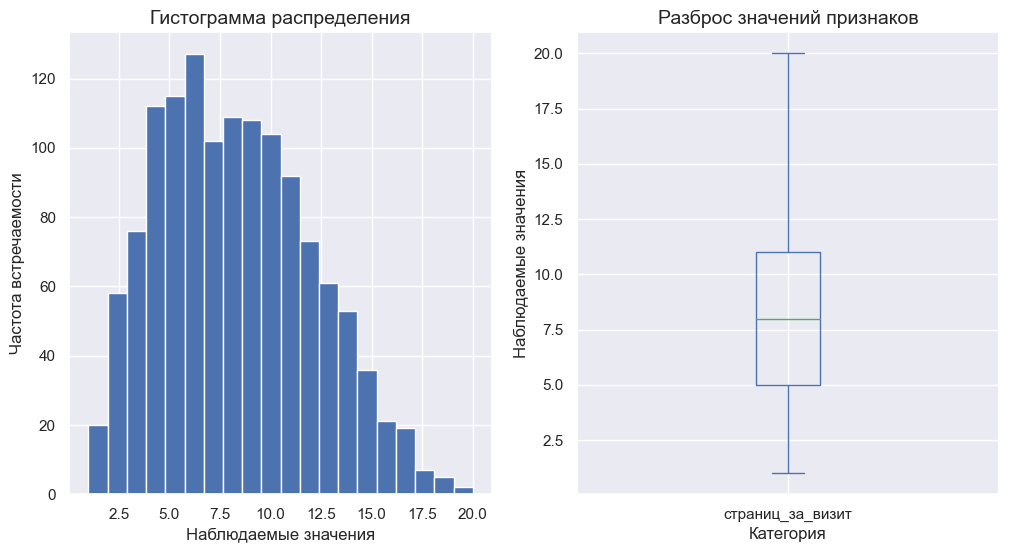

In [192]:
visuals(market, 'страниц_за_визит')

<font size="3">
    
**Вывод**

Признак `cтраниц_за_визит` показывает среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. 
    
Распределение признака имеет положительную ассиметрию, большинство значений располагается в промежутке от 5 до 11 страниц.
    
Выбросы и аномалии отсутствуют.

<font size="3">
    
- **датафрейм revenue**
    
Изучим количественные признаки датафрейма `revenue` с помощью функции `visuals`.

<font size="3">
    
1. Признак **выручка**

count     3,900.000
mean      5,025.696
std       1,777.704
min           0.000
25%       4,590.150
50%       4,957.500
75%       5,363.000
max     106,862.200
Name: выручка, dtype: float64

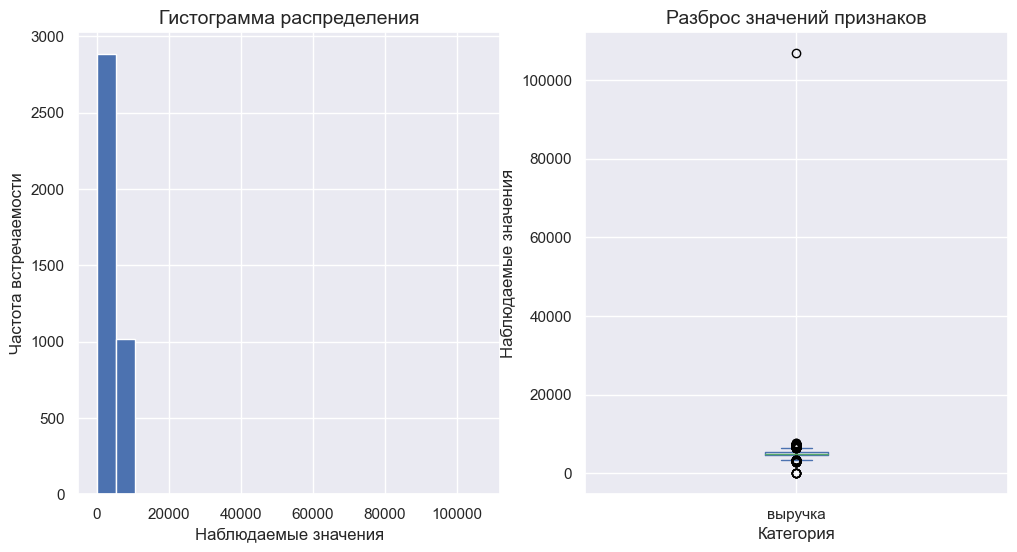

In [193]:
visuals(revenue, 'выручка')


<font size="3">
    
Максимальное значение признака "выручка" сильно отличается от значения Q3, рассмотрим его подробнее.

In [194]:
revenue[revenue['выручка'] > 8000]

id         период     выручка
98  215380  текущий_месяц 106,862.200

<font size="3"> Значение похоже на выброс, однозначно заменить его нельзя, поэтому удалим данную строку из датафрейма:

In [195]:
revenue = revenue[revenue['выручка'] < 8000]

<font size="3">Проверим распределение данных после удаления выброса в разрезе по периодам.
    
- **позапрошлый_месяц:**

count   1,300.000
mean    4,825.207
std       405.980
min         0.000
25%     4,583.000
50%     4,809.000
75%     5,053.500
max     5,663.000
Name: позапрошлый_месяц, dtype: float64

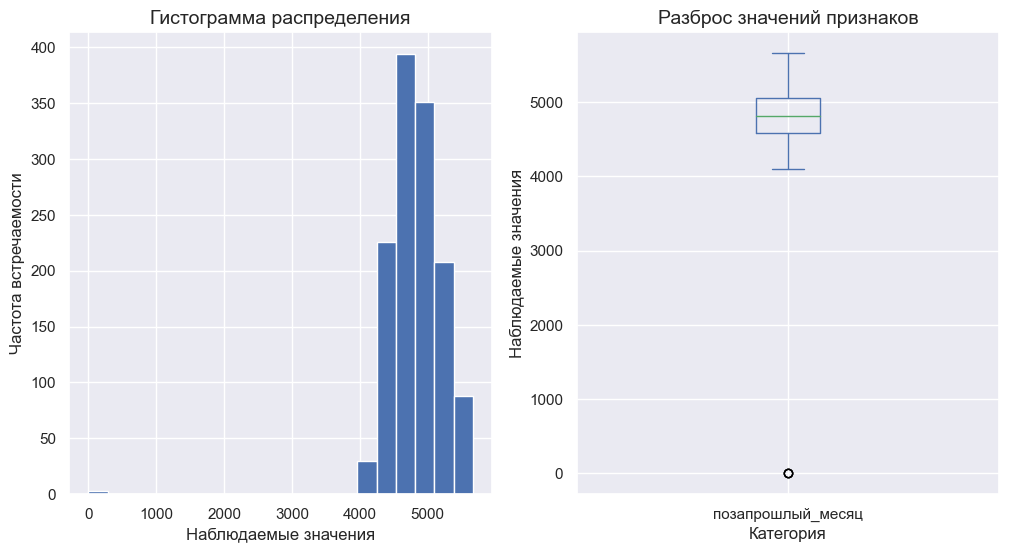

In [196]:
visuals(
    revenue.pivot_table(
    index=['id'],
    columns='период',
    values='выручка', 
    fill_value=0
), 'позапрошлый_месяц')

<font size="3">
    
**Вывод**
    
Признак показывает сумму выручки за период `позапрошлый_месяц`. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 4500 до 5000 со средним значением 4800 рублей.
    
В выборке также есть клиенты, которые не принесли магазину выручку в указанном периоде.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
 
- **предыдущий_месяц:**

count   1,300.000
mean    4,936.920
std       739.598
min         0.000
25%     4,496.750
50%     5,005.000
75%     5,405.625
max     6,869.500
Name: предыдущий_месяц, dtype: float64

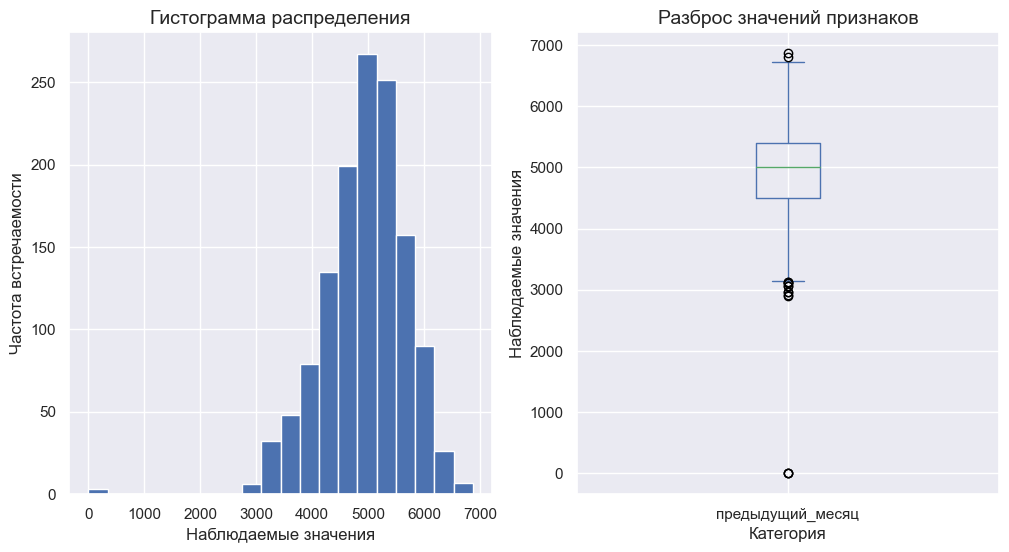

In [197]:
visuals(revenue.pivot_table(
    index=['id'],
    columns='период',
    values='выручка', 
    fill_value=0
), 'предыдущий_месяц')

<font size="3">
    
**Вывод**
    
Признак показывает сумму выручки за период `предыдущий_месяц`. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 4500 до 5500 со средним значением 4900 рублей.
    
В выборке также есть клиенты, которые не принесли магазину выручку в указанном периоде.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
 
- **текущий_месяц:**

count   1,300.000
mean    5,232.759
std       847.689
min         0.000
25%     4,703.850
50%     5,179.550
75%     5,759.275
max     7,799.400
Name: текущий_месяц, dtype: float64

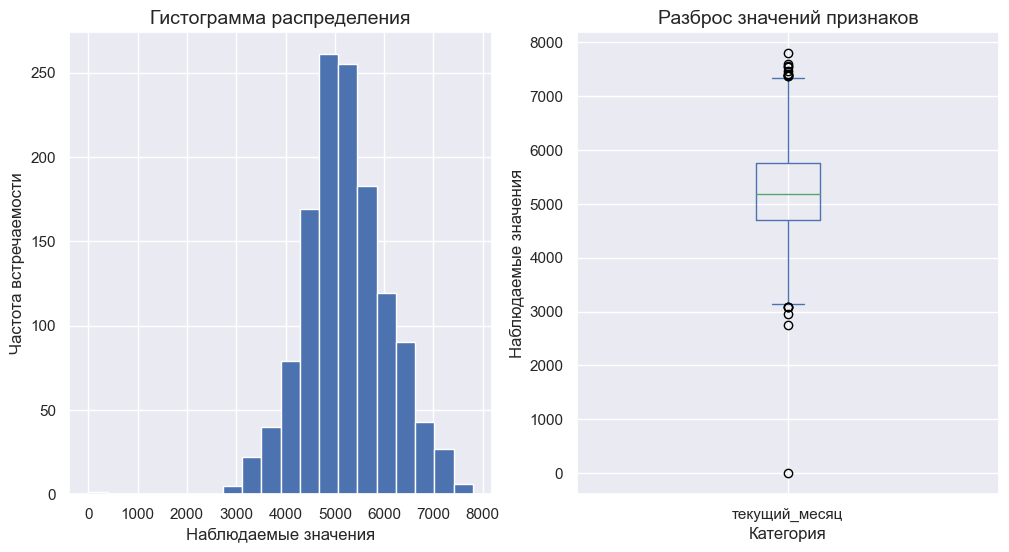

In [198]:
visuals(revenue.pivot_table(
    index=['id'],
    columns='период',
    values='выручка', 
    fill_value=0
), 'текущий_месяц')

<font size="3">
    
**Вывод**

Признак показывает сумму выручки за период `текущий_месяц`. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 4700 до 5800 со средним значением 5200 рублей.
    
В выборке также есть клиенты, которые не принесли магазину выручку в указанном периоде.

Выбросы и аномалии в данных отсутствуют.

---
<font size="3">
    
- **датафрейм time**
    
Изучим количественные признаки датафрейма `time` с помощью функции `visuals` в разрезе представленных периодов.

<font size="3">
    
1. Признак **минут**
    
 
- **предыдущий_месяц:**

count   1,300.000
mean       13.468
std         3.932
min         5.000
25%        11.000
50%        13.000
75%        17.000
max        23.000
Name: предыдущий_месяц, dtype: float64

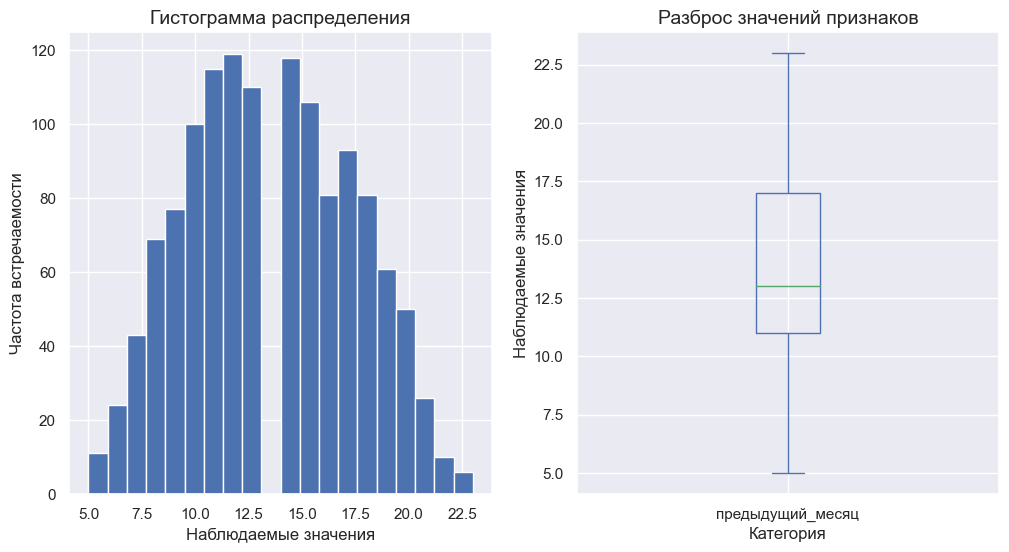

In [199]:
visuals(time.pivot_table(
    index=['id'],
    columns='период',
    values='минут', 
    fill_value=0
), 'предыдущий_месяц')

<font size="3">
    
**Вывод**

Признак отображает значение времени, проведённого на сайте, в указанный период - `предыдущий_месяц`. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 11 до 17 со средним значением в 13 минут.

Выбросы и аномалии в данных отсутствуют.

<font size="3">
    
- **текущий_месяц:**

count   1,300.000
mean       13.205
std         4.221
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: текущий_месяц, dtype: float64

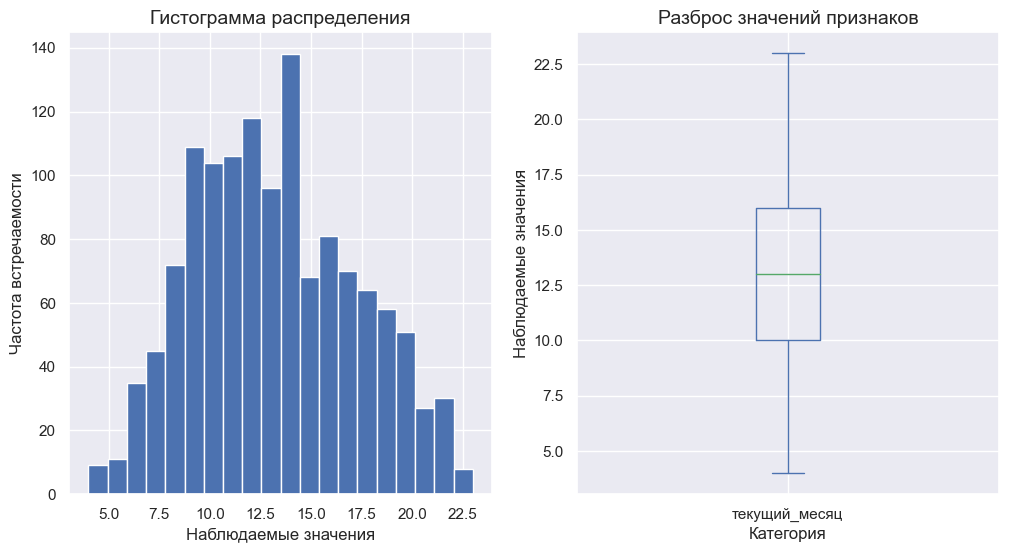

In [200]:
visuals(time.pivot_table(
    index=['id'],
    columns='период',
    values='минут', 
    fill_value=0
), 'текущий_месяц')

<font size="3">
    
**Вывод**

Признак отображает значение времени, проведённого на сайте, в указанный период - `текущий_месяц`. 
    
Признак распределён нормально, большинство значений располагается в промежутке от 10 до 16 со средним значением в 13 минут.

Выбросы и аномалии в данных отсутствуют.

---

### Категориальные признаки

<font size="3">
Изучим категориальные признаки датафреймов.

Напишем функцию, которая визуализирует признак с помощью столбчатой гистограммы:

In [201]:
def cat_visuals(df, cat):
    df[cat].value_counts().plot(
        kind='bar', 
        ylabel='Частота встречаемости',
        rot=45,
        title='Распределение категорий признака ' + cat)

<font size="3">
    
- **датафрейм market**
    
Изучим категориальные признаки датафрейма `market` с помощью функции `cat_visuals`.

<font size="3">
    
1. Признак **"покупательская_активность"**

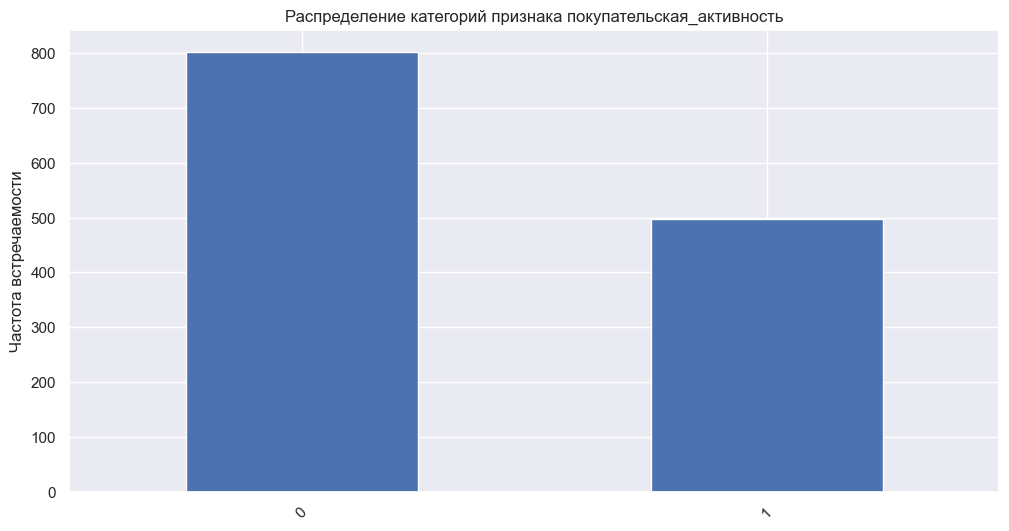

In [202]:
cat_visuals(market, 'покупательская_активность')

<font size="3">
    
**Вывод**

Признак `покупательская_активность` представлен двумя категориями: 
- «прежний уровень»
- «снизилась»

В выборке преобладает категория «прежний уровень».

---
<font size="3">
    
2. Признак **"тип_сервиса"**

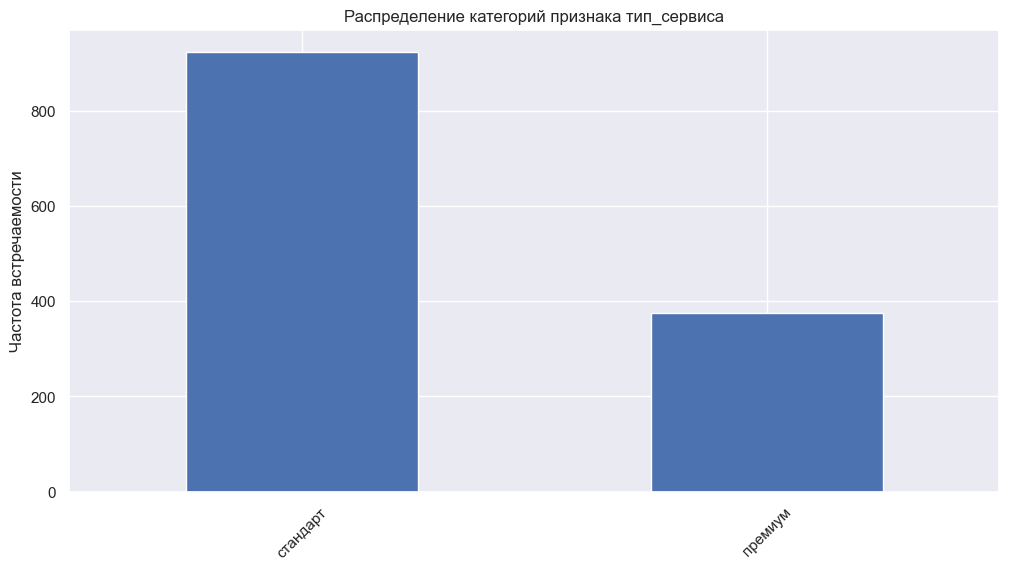

In [203]:
cat_visuals(market, 'тип_сервиса')

<font size="3">
    
**Вывод**

Признак `тип_сервиса` представлен двумя категориями: 
- «стандарт»
- «премиум»

В выборке преобладает категория «стандарт».

---
<font size="3">
    
3. Признак **"разрешить_сообщать"**

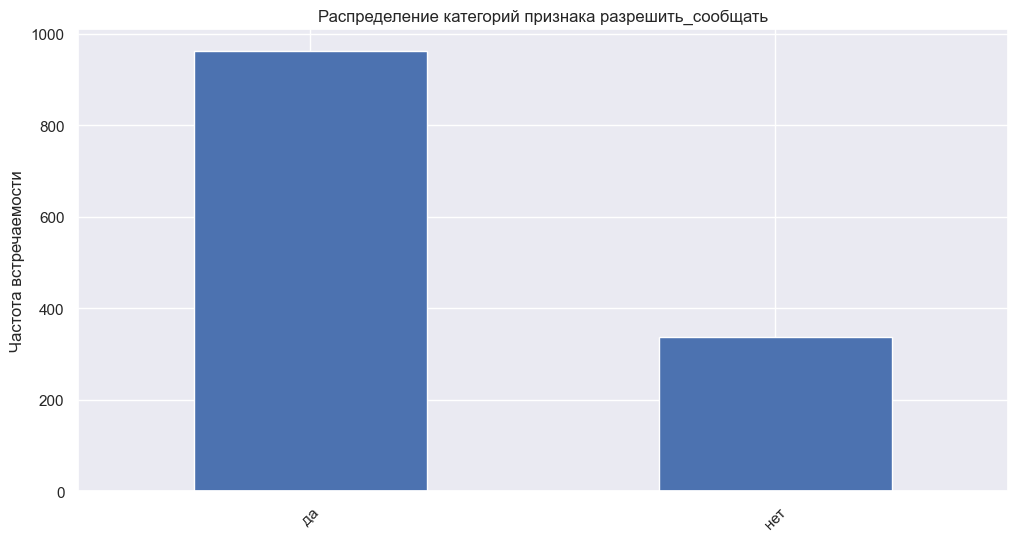

In [204]:
cat_visuals(market, 'разрешить_сообщать')

<font size="3">
    
**Вывод**

Признак `разрешить_сообщать` содержит информацию о согласии пользователя на получение рекламных рассылок. Признак представлен двумя категориями: 
- «да»
- «нет»

В выборке преобладает категория «да».

---
<font size="3">
    
4. Признак **"популярная_категория"**

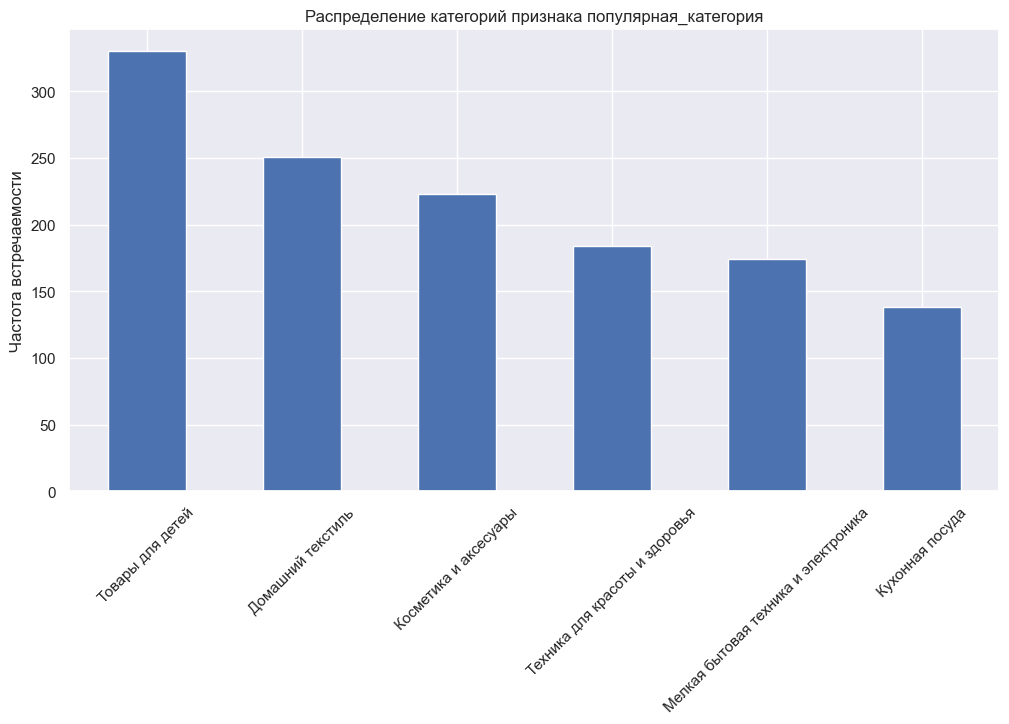

In [205]:
cat_visuals(market, 'популярная_категория')

<font size="3">
    
**Вывод**

Признак `популярная_категория` представлен категориями: 
- «Товары для детей»
- «Домашний текстиль»
- «Косметика и аксесуары»
- «Техника для красоты и здоровья»
- «Мелкая бытовая техника и электроника»
- «Кухонная посуда»
    
В выборке преобладает категория «Товары для детей».

---
<font size="3">
    
- **датафрейм revenue**
    
Изучим категориальны признаки датафрейма `revenue` с помощью функции `cat_visuals`.

<font size="3">
    
1. Признак **"период"**

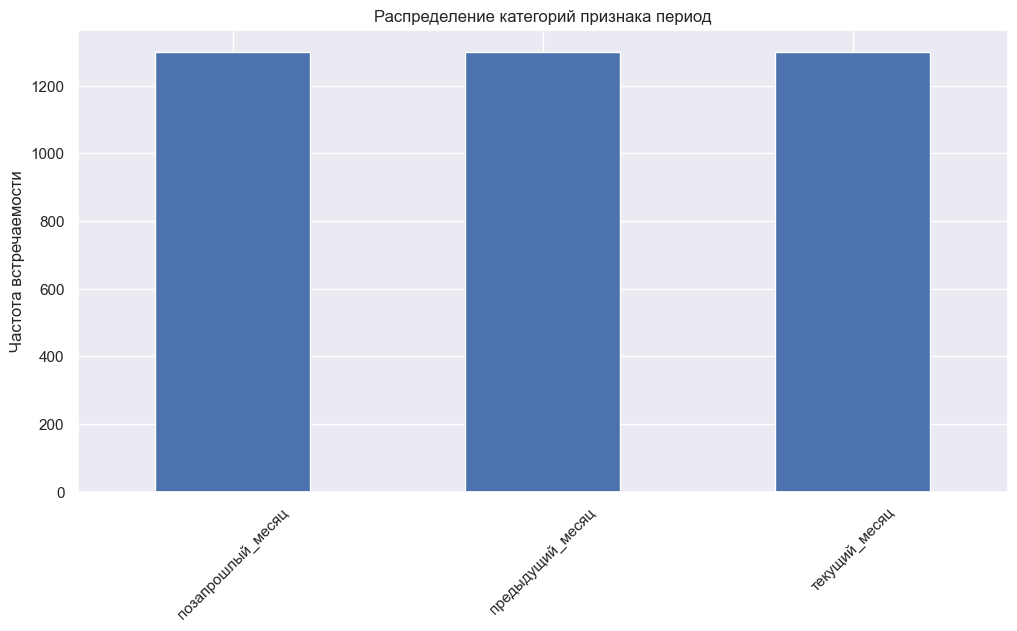

In [206]:
cat_visuals(revenue, 'период')

<font size="3">
    
**Вывод**

Признак `период` представлен категориями: 
- «позапрошлый_месяц»
- «предыдущий_месяц»
- «текущий_месяц»

Категории в выборке представлены равномерно.

---
<font size="3">
    
- **датафрейм time**
    
Изучим категориальны признаки датафрейма `time` с помощью функции `cat_visuals`.

<font size="3">
    
1. Признак **"период"**

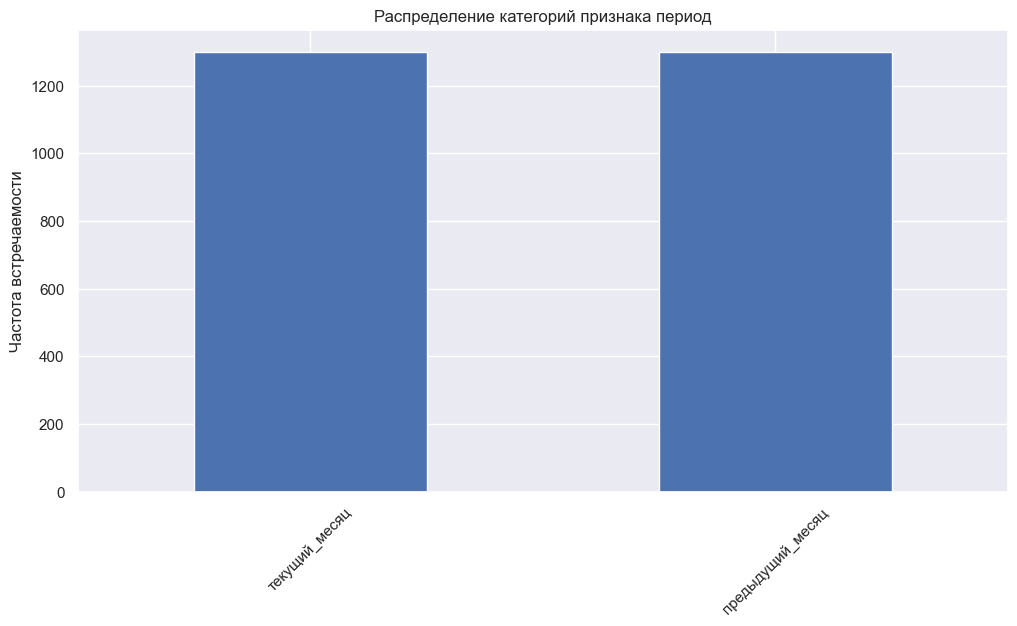

In [207]:
cat_visuals(time, 'период')

<font size="3">
    
**Вывод**

Признак `период` представлен категориями: 
- «предыдущий_месяц»
- «текущий_месяц»

Категории в выборке представлены равномерно.

---
<font size="3">

**Вывод**

- В датафрейме `market` 8 количественных и 4 категориальных признака. 
- В датафреймах `revenue` и `time` 1 количественный и 1 категориальный признак.    
- В датафрейме `profit` 1 количественный признак. 
    
Проведён исследовательский анализ всех признаков, выбросов и аномалий в данных не обнаружено.

## Объединение таблиц

<font size="3"> Перед объединением таблиц отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

### Отбор клиентов

<font size="3"> Изучим данные о выручке, которую магазин получал с покупателей за последние три месяца. Нас интересуют клиенты, которые не осуществляли покупок в указанный период:

In [208]:
revenue.shape

(3899, 3)

In [209]:
grouped = revenue.pivot_table(
    index=['id'],
    columns='период',
    values='выручка', 
    fill_value=0
)

In [210]:
grouped[grouped.isin([0]).any(axis=1)]

период  позапрошлый_месяц  предыдущий_месяц  текущий_месяц
id                                                        
215348                  0             0.000      3,293.100
215357                  0             0.000      5,986.300
215359                  0             0.000      4,735.000
215380               5051         6,077.000          0.000

<font size="3"> Удалим данных покупателей из датафрейма `revenue`:

In [211]:
revenue = revenue.loc[~revenue['id'].isin(grouped[grouped.isin([0]).any(axis= 1)].index.get_level_values(0))]

In [212]:
revenue.shape

(3888, 3)

<font size="3"> Изменения выполнены успешно, из датафрейма `revenue` удалены клиенты, которые не совершали покупок за последние 3 месяца. Учтём данный факт при объединении таблиц.

### Объединение таблиц

<font size="3"> Для корректного отображения данных переформатируем таблицу `revenue` с помощью `pivot_table()`: информация о данных за каждый месяц должна располагаться в отдельных столбцах:

In [213]:
revenue = revenue.pivot_table(index=['id'],columns='период',values='выручка')

<font size="3"> Проверим результат:

In [214]:
revenue.head()

период  позапрошлый_месяц  предыдущий_месяц  текущий_месяц
id                                                        
215349          4,472.000         5,216.000      4,971.600
215350          4,826.000         5,457.500      5,058.400
215351          4,793.000         6,158.000      6,610.400
215352          4,594.000         5,807.500      5,872.500
215353          5,124.000         4,738.500      5,388.500

In [215]:
revenue.shape

(1296, 3)

<font size="3"> Дополнительно переформатируем датафрейм `time` аналогичным образом:

In [216]:
time = time.pivot_table(index=['id'],columns='период',values='минут', fill_value=0)

<font size="3"> Проверим результат:

In [217]:
time.head()

период  предыдущий_месяц  текущий_месяц
id                                     
215348                13             14
215349                12             10
215350                 8             13
215351                11             13
215352                 8             11

<font size="3"> Присоединим датафреймы `revenue` и `time` к датафрейму `market` методом `join()` по ключу `id` с добавлением суффиксов.
    
Дополнительно убедимся, что в выборку не попали удалённые ранее объекты.

In [218]:
print("Датафрейм market до объединения:" , market.shape)
print("Датафрейм revenue до объединения::" , revenue.shape)

Датафрейм market до объединения: (1300, 13)
Датафрейм revenue до объединения:: (1296, 3)


In [219]:
market = market.join(revenue.add_suffix('_выручка'), on='id', how='right')

<font size="3"> Проверим результат:

In [220]:
market.head()

id  покупательская_активность тип_сервиса разрешить_сообщать  \
1  215349                          1     премиум                 да   
2  215350                          1    стандарт                нет   
3  215351                          1    стандарт                 да   
4  215352                          1    стандарт                нет   
5  215353                          1    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1               4.400                     4           819              0.750   
2               4.900                     3           539              0.140   
3               3.200                     5           896              0.990   
4               5.100                     3          1064              0.940   
5               3.300                     4           762              0.260   

  популярная_категория  средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   
5    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   
5                                   1               1                 4   

   позапрошлый_месяц_выручка  предыдущий_месяц_выручка  текущий_месяц_выручка  
1                  4,472.000                 5,216.000              4,971.600  
2                  4,826.000                 5,457.500              5,058.400  
3                  4,793.000                 6,158.000              6,610.400  
4                  4,594.000                 5,807.500              5,872.500  
5                  5,124.000                 4,738.500              5,388.500

In [221]:
print("Датафрейм market после объединения с revenue:" , market.shape)

Датафрейм market после объединения с revenue: (1296, 16)


<font size="3"> Аналогично присоединим датафрейм `time`:

In [222]:
print("Датафрейм time до объединения:" , time.shape)

Датафрейм time до объединения: (1300, 2)


In [223]:
market = market.join(time.add_suffix('_время'), on='id', how='left')

<font size="3"> Проверим результат:

In [224]:
market.head()

id  покупательская_активность тип_сервиса разрешить_сообщать  \
1  215349                          1     премиум                 да   
2  215350                          1    стандарт                нет   
3  215351                          1    стандарт                 да   
4  215352                          1    стандарт                нет   
5  215353                          1    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1               4.400                     4           819              0.750   
2               4.900                     3           539              0.140   
3               3.200                     5           896              0.990   
4               5.100                     3          1064              0.940   
5               3.300                     4           762              0.260   

  популярная_категория  средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   
5    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   
5                                   1               1                 4   

   позапрошлый_месяц_выручка  предыдущий_месяц_выручка  текущий_месяц_выручка  \
1                  4,472.000                 5,216.000              4,971.600   
2                  4,826.000                 5,457.500              5,058.400   
3                  4,793.000                 6,158.000              6,610.400   
4                  4,594.000                 5,807.500              5,872.500   
5                  5,124.000                 4,738.500              5,388.500   

   предыдущий_месяц_время  текущий_месяц_время  
1                      12                   10  
2                       8                   13  
3                      11                   13  
4                       8                   11  
5                      10                   10

In [225]:
print("Датафрейм market после объединения с time:" , market.shape)

Датафрейм market после объединения с time: (1296, 18)


---
<font size="3">
    
**Вывод**
    
Таблицы успешно объединены, в выборку не попали клиенты, которые не совершали покупок за последние 3 месяца.

## Корреляционный анализ

<font size="3"> Проведём корреляционный анализ признаков в датафрейме `market`. 

При дальнейшем обучении модели признак `покупательская_активность` будет являться целевым, изучим взаимосвязь данного признака с остальными признаками датафрейма и выявим мультиколлинеарность признакового описания при его наличии.

<font size="3"> Корреляцию признаков рассмотрим с помощью матрицы корреляций `phik_matrix()`:

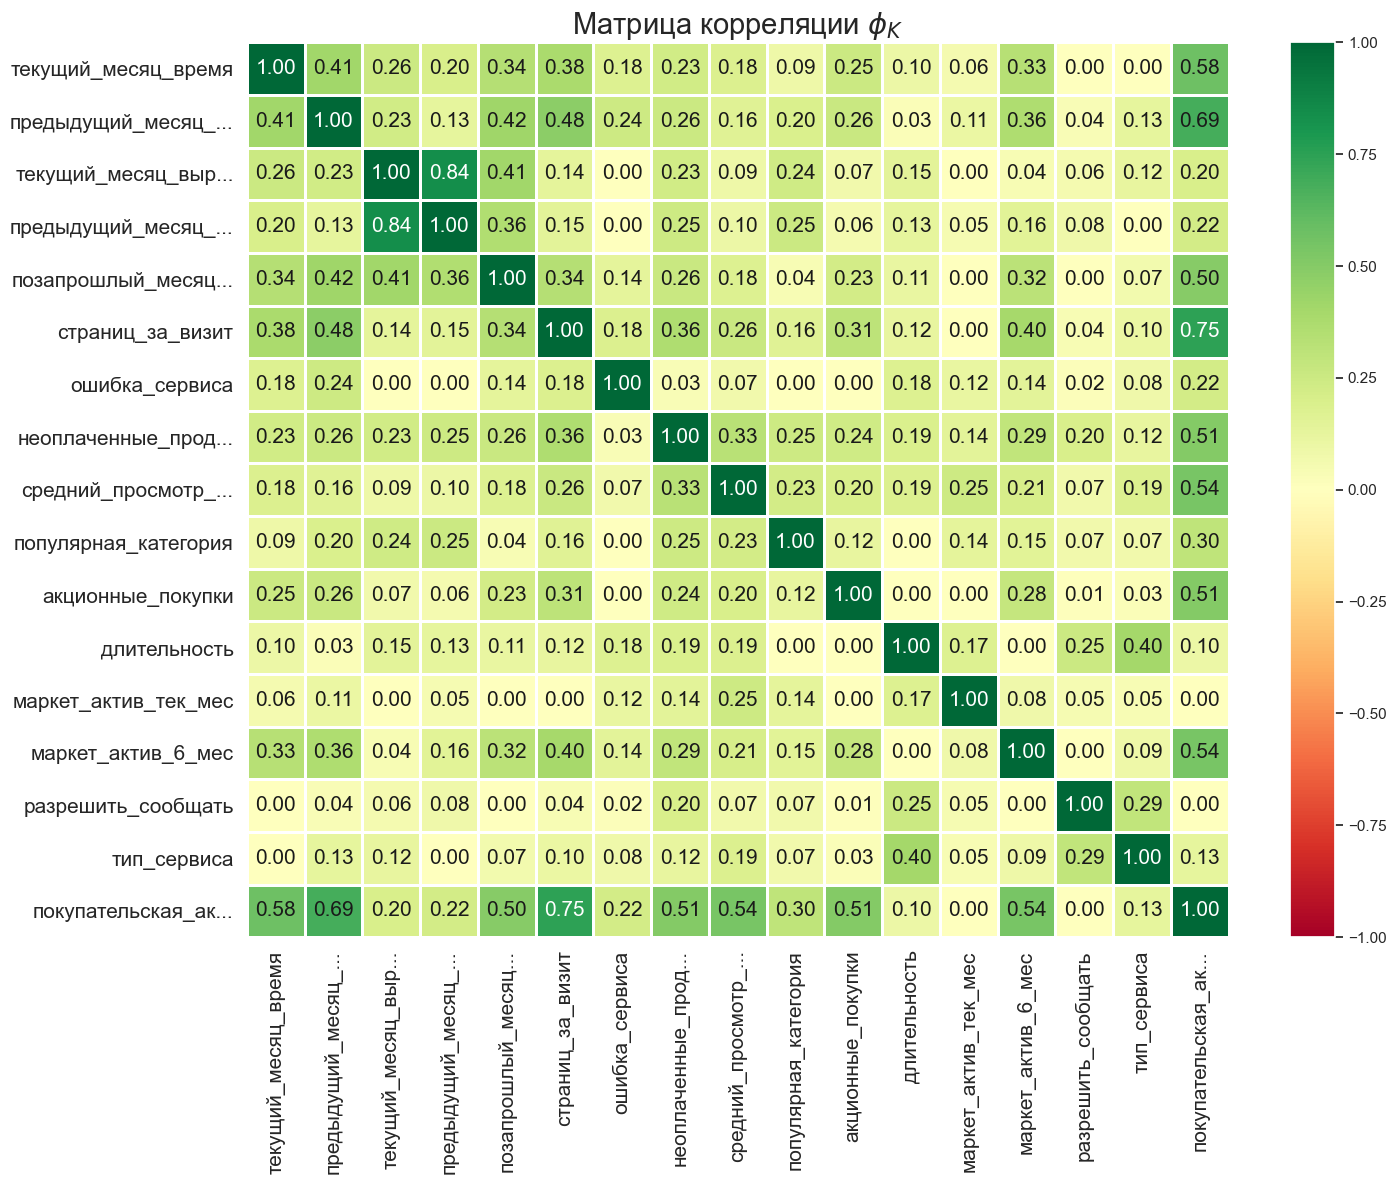

In [226]:
# список интервальных признаков
interval_cols = market.loc[:,'покупательская_активность' : 'текущий_месяц_время']\
                      .select_dtypes(include='number').columns.tolist()

# вычисление коэффициентов корреляции phi для датафрейма ferma
phik_overview = market.loc[:,'покупательская_активность' : 'текущий_месяц_время']\
                      .phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

<font size="3">

**Вывод**

Высокая зависимость с целевым признаком `покупательская_активность` выявлена у признаков: 
- `предыдущий_месяц_время`
- `cтраниц_за_визит`

Заметная зависимость у признаков:
- `текущий_месяц_время` 
- `неоплаченные_продукты_штук_квартал`
- `средний_просмотр_категорий_за_визит`
- `акционные_покупки`
- `маркет_актив_6_мес`

У остальных входных признаков умеренная либо слабая зависимость с целевым.

Мультиколлинеарность входных признаков не выявлена.

---
### Целевой признак

<font size="3"> Дополнительно изучим сопряжённость целевого признака `покупательская_активность` и входных признаков.

#### Количественные признаки

<font size="3"> Напишем функцию `numeric()` для отображения распределения количественных признаков датафрейма в разрезе целевого признака `покупательская_активность`.

In [227]:
def numeric(col):
    sns.histplot(x = col, hue = 'покупательская_активность', data = market, bins = 20)
    
    plt.title("Распределение признака " + col + " в разрезе покупательской активности клиентов")
    plt.xlabel("наблюдаемые значения")
    plt.ylabel("частота встречаемости");

<font size="3">
    
- Признак **маркет_ актив_ 6_мес**

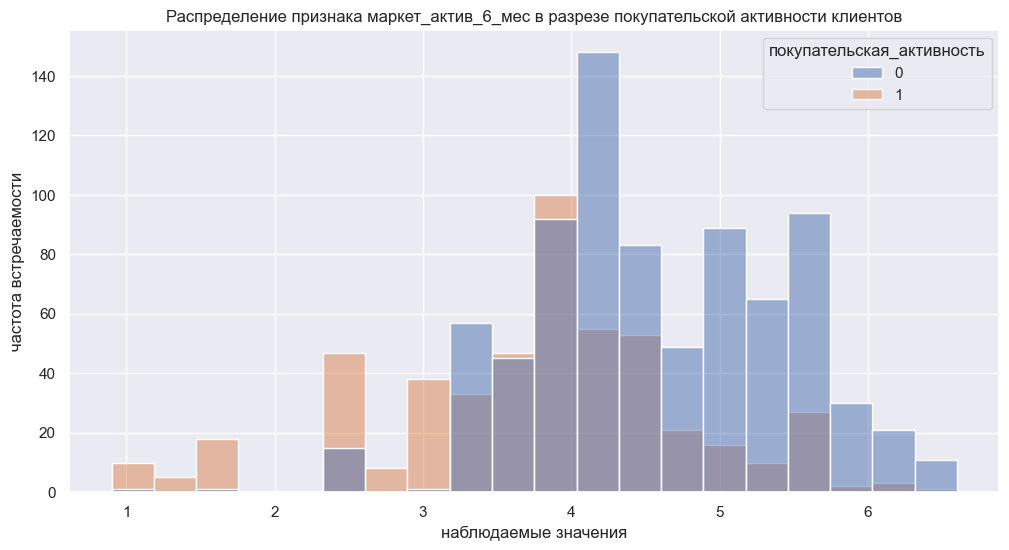

In [228]:
numeric ('маркет_актив_6_мес')

<font size="3">

**Вывод**
    
Можно отметить, что клиентам с прежним уровнем покупательской активности соответствует больший уровень маркетинговой активности за последние 6 месяцев.
    
Клиенты с уровнем покупательской активности "снизилась" получали меньшее количество маркетинговых коммуникаций в данный период. 

---
<font size="3">
    
- Признак **маркет_актив_тек_мес**

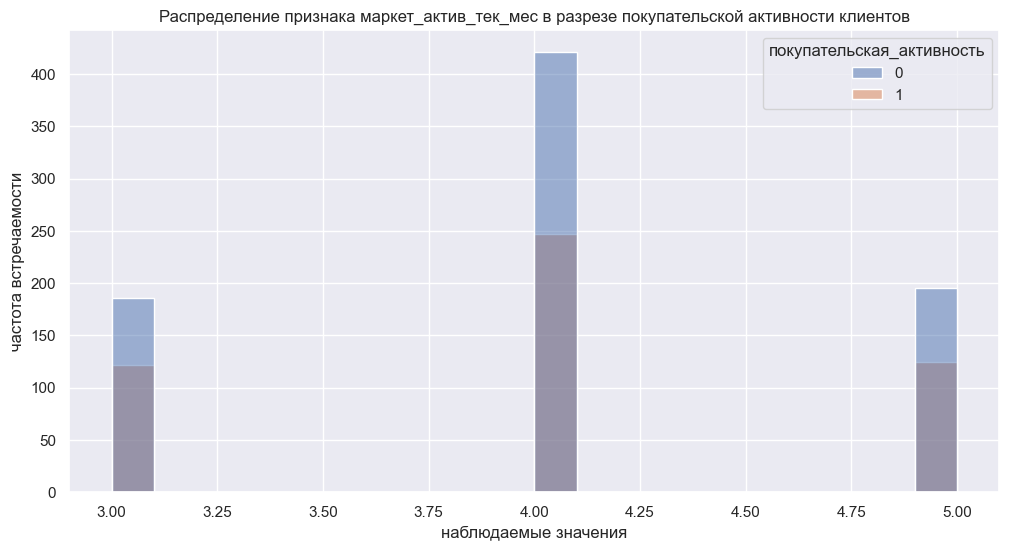

In [229]:
numeric ('маркет_актив_тек_мес')

<font size="3">

**Вывод**
    
Маркетинговая активность в текущем месяце однородна: наиболее часто встречаемое значение в 4 коммуникации соответствует обоим уровням покупательской активности.

---
<font size="3">
    
- Признак **длительность**

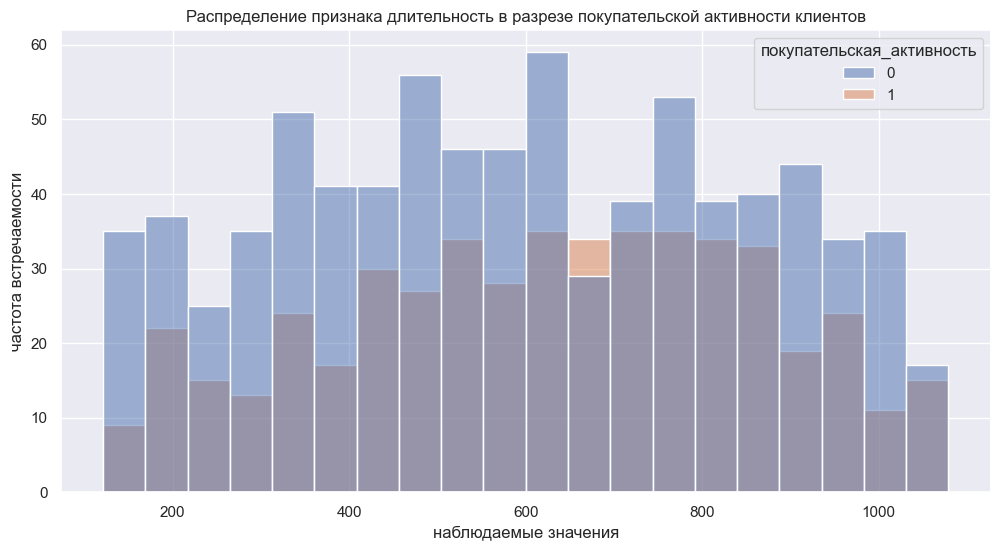

In [230]:
numeric ('длительность')

<font size="3">

**Вывод**
    
Количество дней с момента регистрации покупателя на сайте также однородно для обоих уровней покупательской активности.

---
<font size="3">
    
- Признак **акционные_покупки**

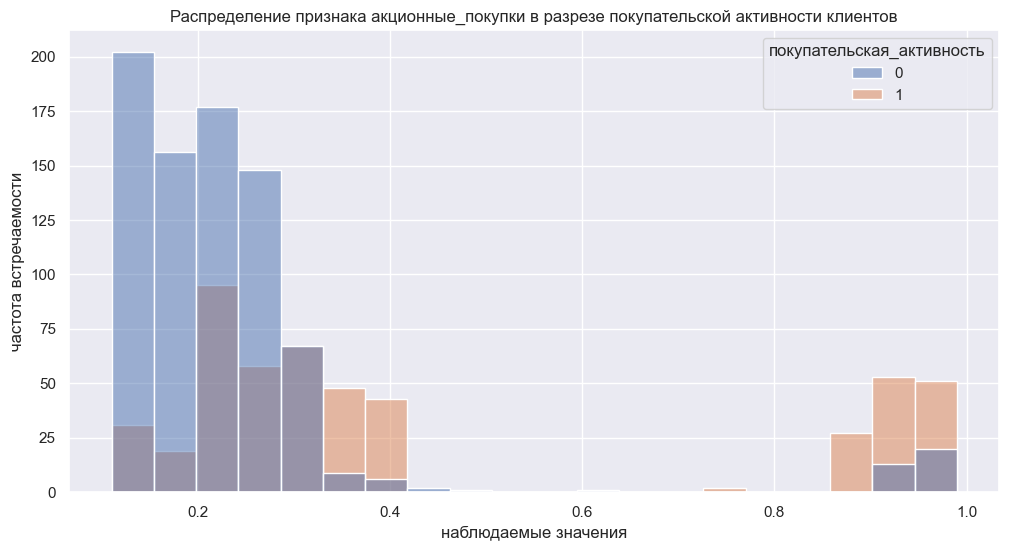

In [231]:
numeric ('акционные_покупки')

<font size="3">

**Вывод**
    
Можно отметить, что клиентам с прежним уровнем покупательской активности соответствует меньшая доля покупок по акции от общего числа покупок за последние 6 месяцев.
    
Клиенты с уровнем покупательской активности "снизилась" приобретали больше акционных товаров в данный период. 

---
<font size="3">
    
- Признак **средний_просмотр_категорий_за_визит**

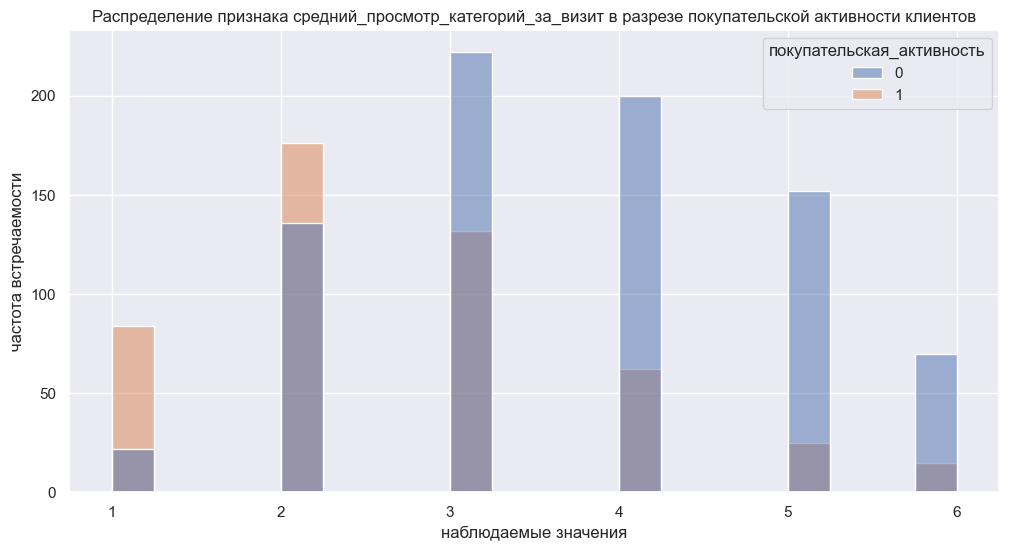

In [232]:
numeric ('средний_просмотр_категорий_за_визит')

<font size="3">

**Вывод**
    
Клиенты с прежним уровнем покупательской активности в среднем просматривают больше категорий товаров за визит.
    
Клиенты с уровнем покупательской активности "снизилась" чаще всего ограничиваются двумя категориями.

---
<font size="3">
    
- Признак **неоплаченные_продукты_штук_квартал**

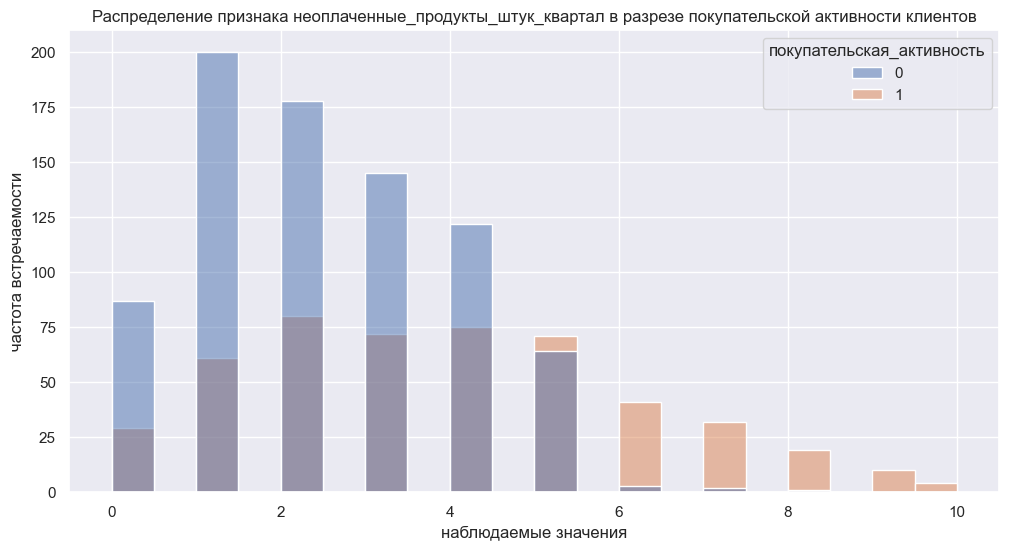

In [233]:
numeric ('неоплаченные_продукты_штук_квартал')

<font size="3">

**Вывод**
    
Клиенты с прежним уровнем покупательской активности практически не откладывают покупку выбранных продуктов и имеют меньше неоплаченных товаров за квартал.
    
Клиенты с уровнем покупательской активности "снизилась" чаще всего откладывают покупку товаров. Возможно, это связано с признаком "акционные_покупки": пользователи откладывают покупку до наступления акции на данный товар. 

---
<font size="3">
    
- Признак **ошибка_сервиса**

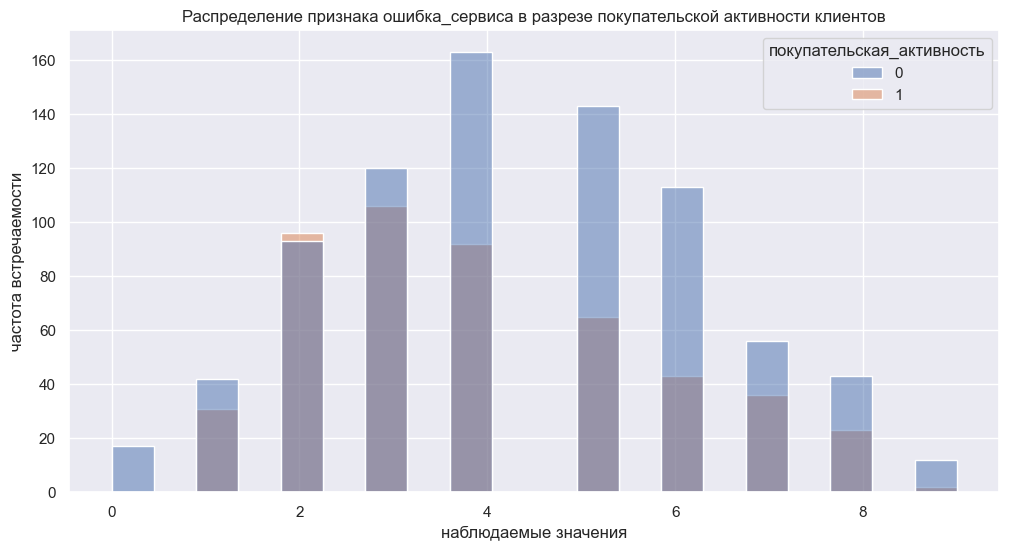

In [234]:
numeric ('ошибка_сервиса')

<font size="3">

**Вывод**
    
Число сбоев, которые коснулись покупателя во время посещения сайта, однородно для обоих уровней покупательской активности: большинство клиентов с прежним уровнем покупательской активности столкнулись с 4 сбоями системы, а большинство клиентов с уровнем покупательской активности "снизилась" - с 3 сбоями.

---
<font size="3">
    
- Признак **cтраниц_за_визит**

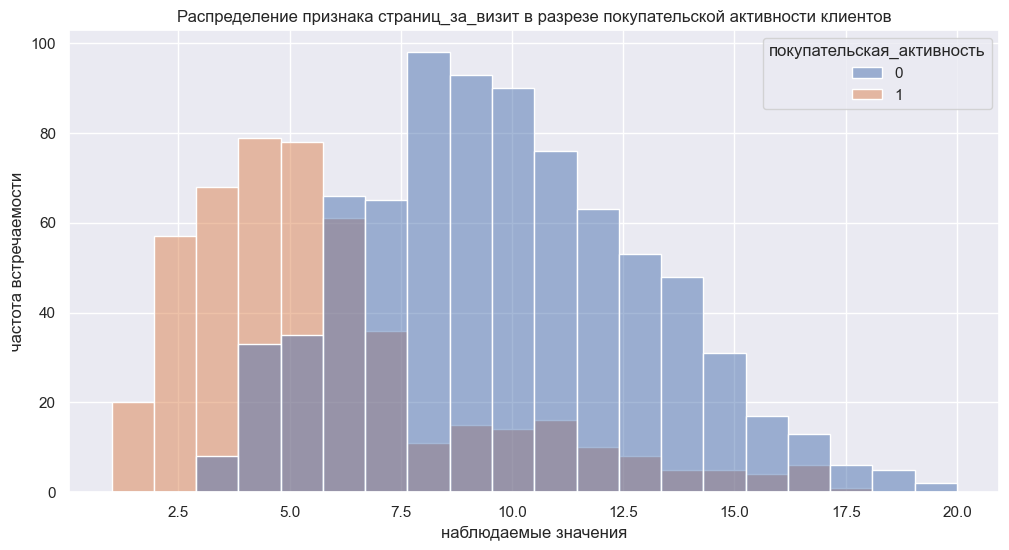

In [235]:
numeric ('страниц_за_визит')

<font size="3">

**Вывод**
    
Клиенты с прежним уровнем покупательской активности в среднем просматривают больше страниц сайта за одно посещение.
    
Клиентам с уровнем покупательской активности "снизилась" свойственно просматривать меньше страниц сайта. Возможно, это также связано повышенным интересом данной группы пользователей к акционным товарам: во время посещения сайта клиетов интересуют только те страницы сайта, где присутствуют акции и скидки.

---
<font size="3">
    
- Признак **позапрошлый_месяц_выручка**

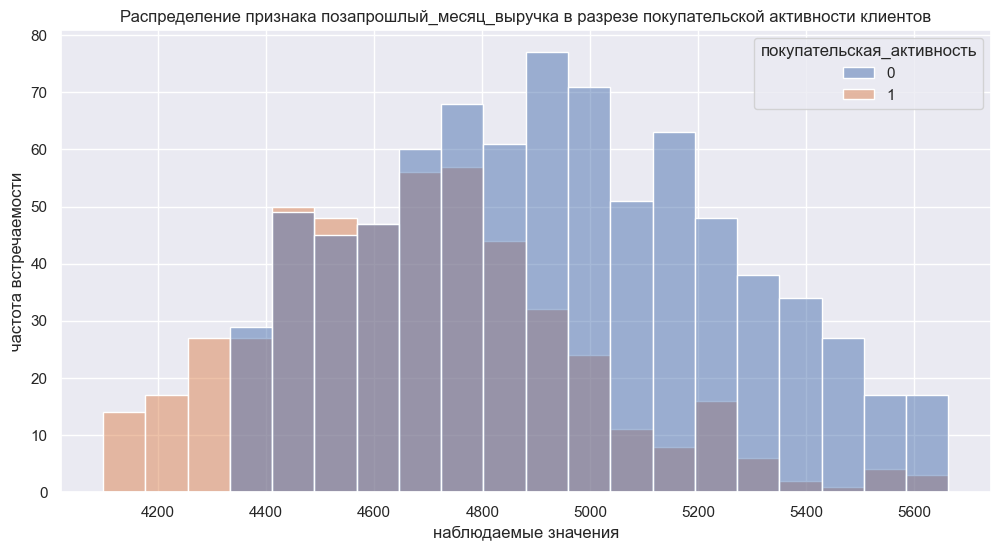

In [236]:
numeric ('позапрошлый_месяц_выручка')

<font size="3">

**Вывод**
    
Клиенты с прежним уровнем покупательской активности в среднем принесли магазину бóльшую выручку в позапрошлом месяце: от 4500 до 5500 рублей.
    
Клиентам с уровнем покупательской активности "снизилась" соответствует меньшая выручка: от 4200 до 5000 рублей. Среди данной категории клиентов также есть пользователи, которые не принесли магазину выручку в позапрошлом месяце.

---
<font size="3">
    
- Признак **предыдущий_месяц_выручка**

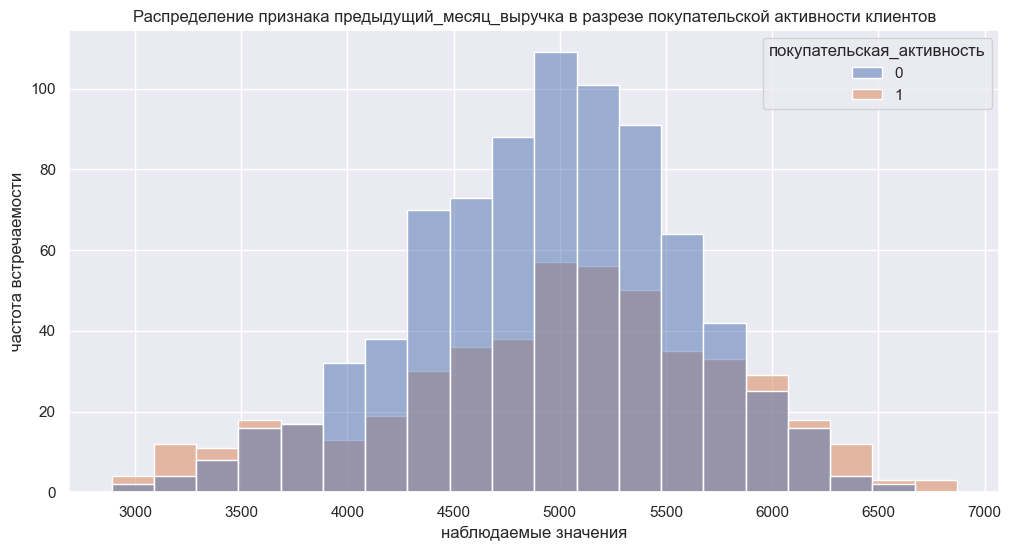

In [237]:
numeric ('предыдущий_месяц_выручка')

<font size="3">

**Вывод**
    
Суммарная выручка, полученная магазином в предыдущем месяце, однородна для обоих уровней покупательской активности.

---
<font size="3">
    
- Признак **текущий_месяц_выручка**

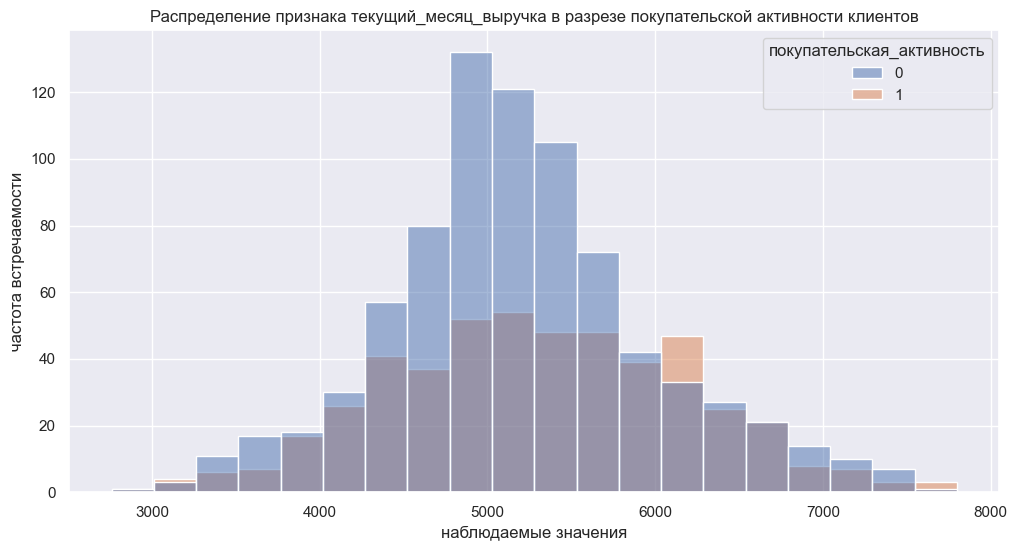

In [238]:
numeric ('текущий_месяц_выручка')

<font size="3">

**Вывод**
    
Суммарная выручка, полученная магазином в текущем месяце, однородна для обоих уровней покупательской активности.

---
<font size="3">
    
- Признак **предыдущий_месяц_время**

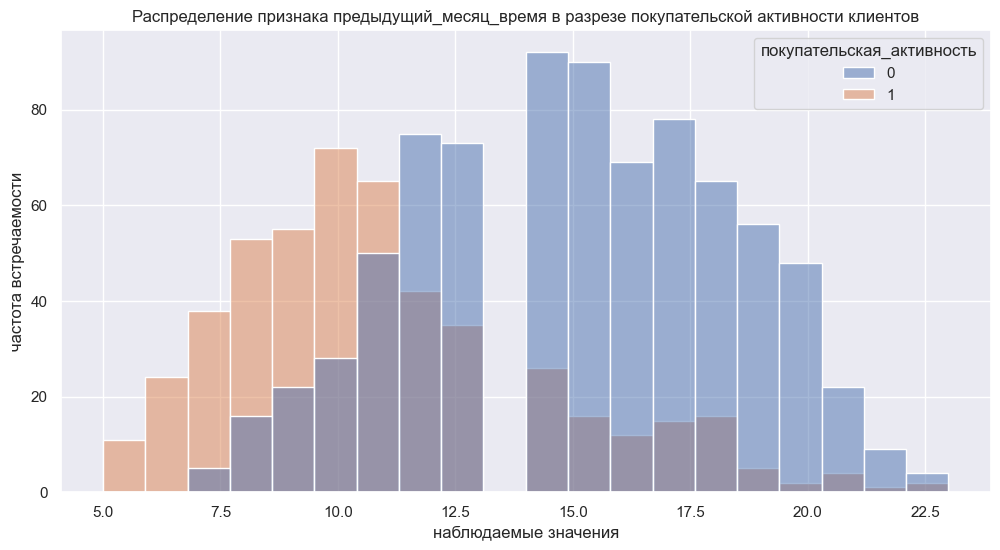

In [239]:
numeric ('предыдущий_месяц_время')

<font size="3">

**Вывод**
    
Клиенты с прежним уровнем покупательской активности в среднем провели больше времени на сайте в предыдущем месяце, чем клиенты с уровнем покупательской активности "снизилась".
    
Данный вывод соответствует признаку "страниц за визит": клиенты с прежним уровнем покупательской активности просматривают больше страниц сайта за визит.

---
<font size="3">
    
- Признак **текущий_месяц_время**

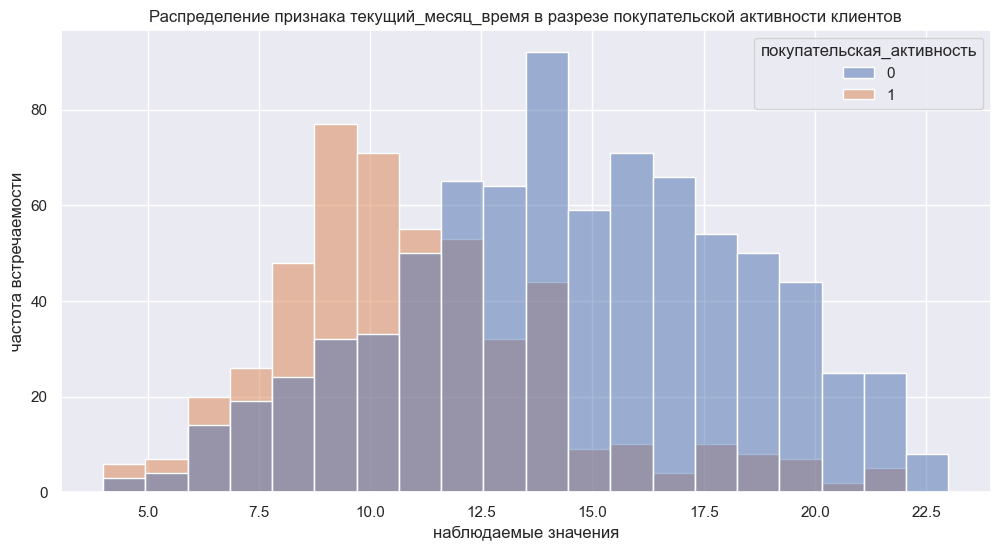

In [240]:
numeric ('текущий_месяц_время')

<font size="3">

**Вывод**
    
В текущем месяце клиенты с прежним уровнем покупательской активности также провели больше времени на сайте, чем клиенты с уровнем покупательской активности "снизилась".

#### Категориальные признаки

<font size="3"> Напишем функцию `categorial()` для отображения сопряжённости категориальных признаков датафрейма с целевым признаком `покупательская_активность`.

In [241]:
def categorial (cat):
    pd.crosstab(
        market['покупательская_активность'], 
        market[cat]
    ).plot.bar(rot = 0)
    
    plt.title("Сопряжённость признаков покупательская_активность и " + cat)
    plt.xlabel("покупательская  активность")
    plt.ylabel("частота встречаемости"); 

---
<font size="3">
    
- Признак **тип_сервиса**

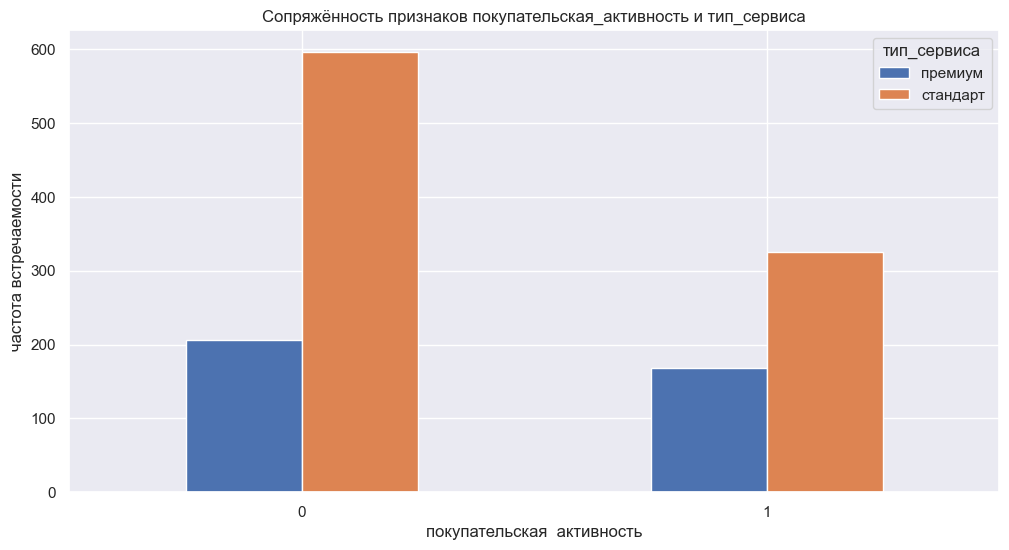

In [242]:
categorial ('тип_сервиса')

<font size="3">

**Вывод**
    
В обеих категориях покупательской активности пользователей преобладает тип сервиса "Стандарт".

---
<font size="3">
    
- Признак **разрешить_сообщать**

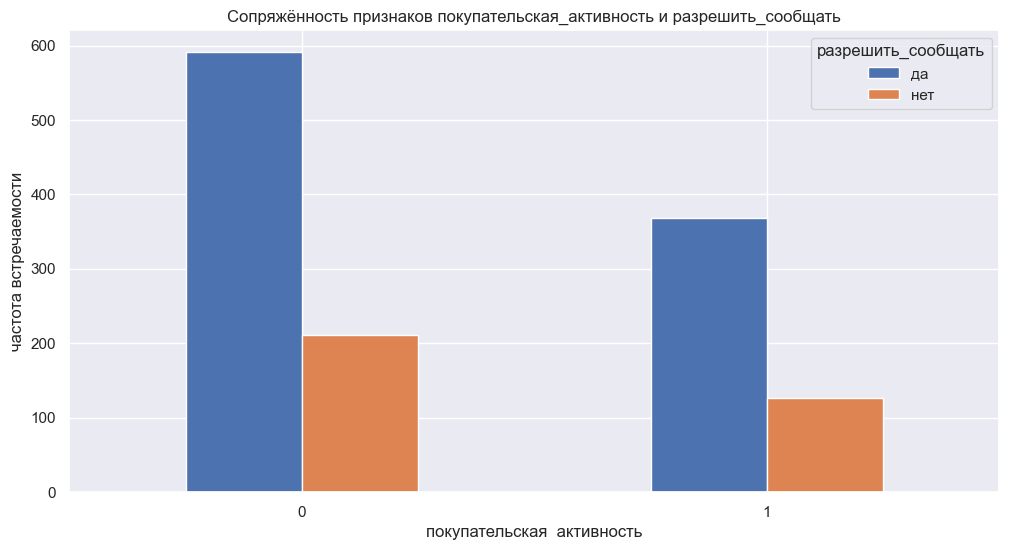

In [243]:
categorial ('разрешить_сообщать')

<font size="3">

**Вывод**
    
В обеих категориях покупательской активности пользователей преобладает разрешение на получение маркетинговых коммуникаций.

---
<font size="3">
    
- Признак **популярная_категория**

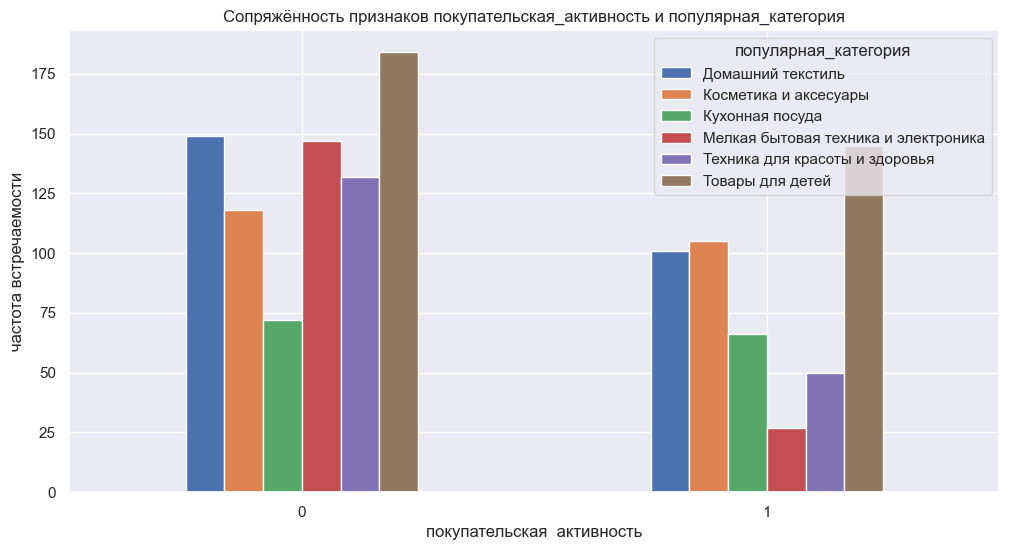

In [244]:
categorial ('популярная_категория')

<font size="3">

**Вывод**
    
В обеих категориях покупательской активности пользователей преобладает категория "Товары для детей".
    
Наименее популярная категория среди клиентов с прежним уровнем покупательской активности - "Кухонная посуда", а среди клиентов с уровнем покупательской активности "снизилась" - "Мелкая бытовая техника и электроника".

---

<font size="3">

**Вывод**
    
Проведён корреляционный анализ датафрейма `market` и графическое исследование сопряжённости целевого признака `покупательская_активность` и входных признаков.
    
    
Высокая зависимость с целевым выявлена у следующих признаков: 
- `предыдущий_месяц_время`
- `cтраниц_за_визит`
    
Мультиколлинеарность входных признаков не выявлена.

## Пайплайн

<font size="3">
    
Создадим пайплайн по следующему алгоритму: 
- обозначим тип исходных данных;
- зададим алгоритм работы с данными кодировщику `OneHotEncoder`;
- зададим алгоритм работы с данными для `OrdinalEncoder`;
- объединим кодирование и масштабирование в шаге `data_preprocessor`;
- создадим итоговый пайплайн, где соберём шаг с моделированием данных и инициализацию модели;
- создадим словарь для перебора моделей и гиперпараметров;
- зададим перебор моделей и гиперпараметров методом `GridSearchCV`.
    
Передадим пайплайну 4 модели:
  - `DecisionTreeClassifier()`, 
  - `KNeighborsClassifier()`, 
  - `SVC()`,
  - `LogisticRegression()`.

Для каждой модели подберём свои гиперпараметры.
    
Для кодирования категориальных признаков используем два кодировщика, а для масштабирования количественных признаков переберём несколько скейлеров для каждой модели.

Для оценки работы моделей используем метрику `roc_auc`: она оценит качество решений моделей в наиболее общем виде, учитывая все возможные пороговые значения.

In [122]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['покупательская_активность', 'id'], axis=1),
    market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['покупательская_активность']
)


# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = X_train.select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков + OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ord',  OrdinalEncoder(
                categories=[['стандарт', 'премиум']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-900))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
      # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

<font size="3"> Определим лучшую модель на данных тренировочной выборки и выведем её параметры:

In [123]:
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': SVC(C=2, probability=True, random_state=42), 'models__C': 2, 'preprocessor__num': StandardScaler()}


<font size="3"> 
    
Лучше всего на тренировочных данных показал себя метод опорных векторов `SVC()` с параметром регуляризации `C=1` и методом масштабирования количественных данных `StandardScaler()`.
    
Выведем метрику лучшей модели: 

In [124]:
y_pred = grid.predict_proba(X_test)[:,1]
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred):.2f}')

Метрика лучшей модели на кросс-валидационной выборке: 0.9091302236120418
Метрика ROC-AUC на тестовой выборке: 0.91


<font size="3"> 
    
**Вывод**
    
На данном этапе исследования написан общий пайплайн для перебора четырёх моделей с подбором гиперпараметров, который определил лучшую модель с помощью метрики `ROC-AUC`.
    
Лучше всего на тренировочных данных себя показал метод опорных векторов `SVC()` с параметром регуляризации `C=1` и методом масштабирования количественных данных `StandardScaler()`.
    
Результат работы модели удовлетворительный: 
- Метрика лучшей модели на кросс-валидационной выборке: 0.9091302236120418
- Метрика ROC-AUC на тестовой выборке: 0.91    

## Анализ важности признаков

<font size="3"> Изучим важность признаков для лучшей модели с помощью метода SHAP. 
    
Подготовим `shap.Explainer()`:

In [128]:
explainer = shap.KernelExplainer(
    grid.best_estimator_.named_steps['models'].predict_proba, 
    grid.best_estimator_[-2].transform(X_test), 
    feature_names = grid.best_estimator_[-2].get_feature_names_out()
)

Using 324 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [129]:
sample = shap.sample(grid.best_estimator_[-2].transform(X_test), 50)

<font size="3"> Получим значения Шепли:

In [130]:
shap_values_sec = explainer(sample)

  0%|          | 0/50 [00:00<?, ?it/s]

<font size="3">
    
Для визуализации вклада признаков в каждое предсказание модели построим диаграммы `shap.plots.bar` и `shap.plots.beeswarm`:

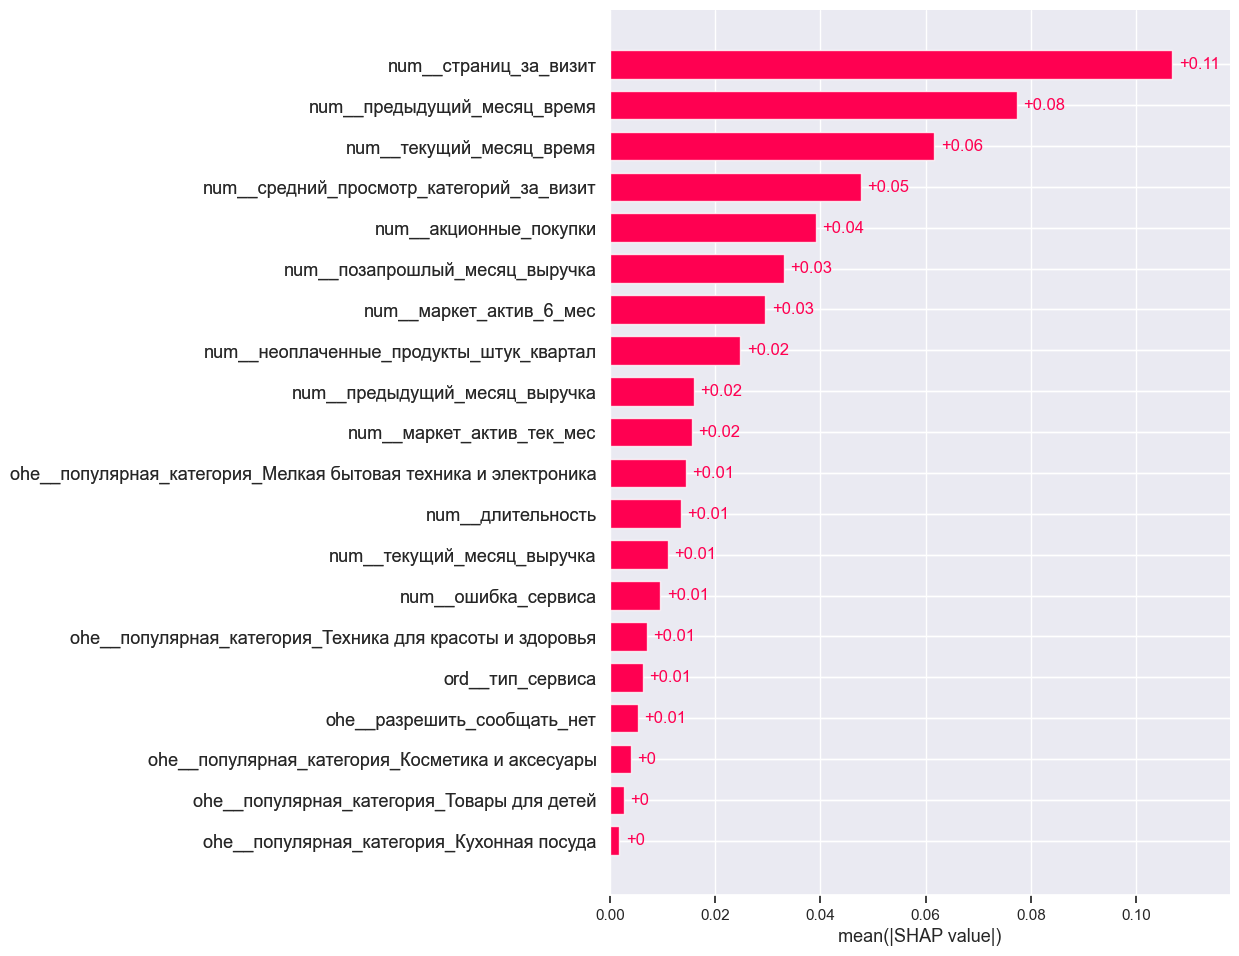

In [131]:
shap.plots.bar(shap_values_sec[:, :, 1], max_display=20)

<font size="3">
    
**Вывод**
    
Больше всего на прогнозы модели влияют следующие признаки:
- `num__cтраниц_за_визит` - признак с наибольшим влиянием;
- `num__текущий_месяц_время`;
- `num__предыдущий_месяц_время`;
- `num__акционные_покупки`;
- `num__средний_просмотр_категорий_за_визит`;
- `num__неоплаченные_продукты_штук_квартал`;
- `num__маркет_актив_6_мес`;
- `num__позапрошлый_месяц_выручка`
    
Меньше всего на прогнозы модели влияют признаки: 
    
- `ord__тип_сервиса`;
- `ohe__популярная_категория`;
- `ohe__разрешить_сообщать_нет`
    
Можно заключить, что модель сочла активность клиентов на сайте наиболее ценной для построения прогноза, тогда как предпочтения клиентов ("популярная категория товаров" и "тип сервиса") практически не влияют на решение модели.

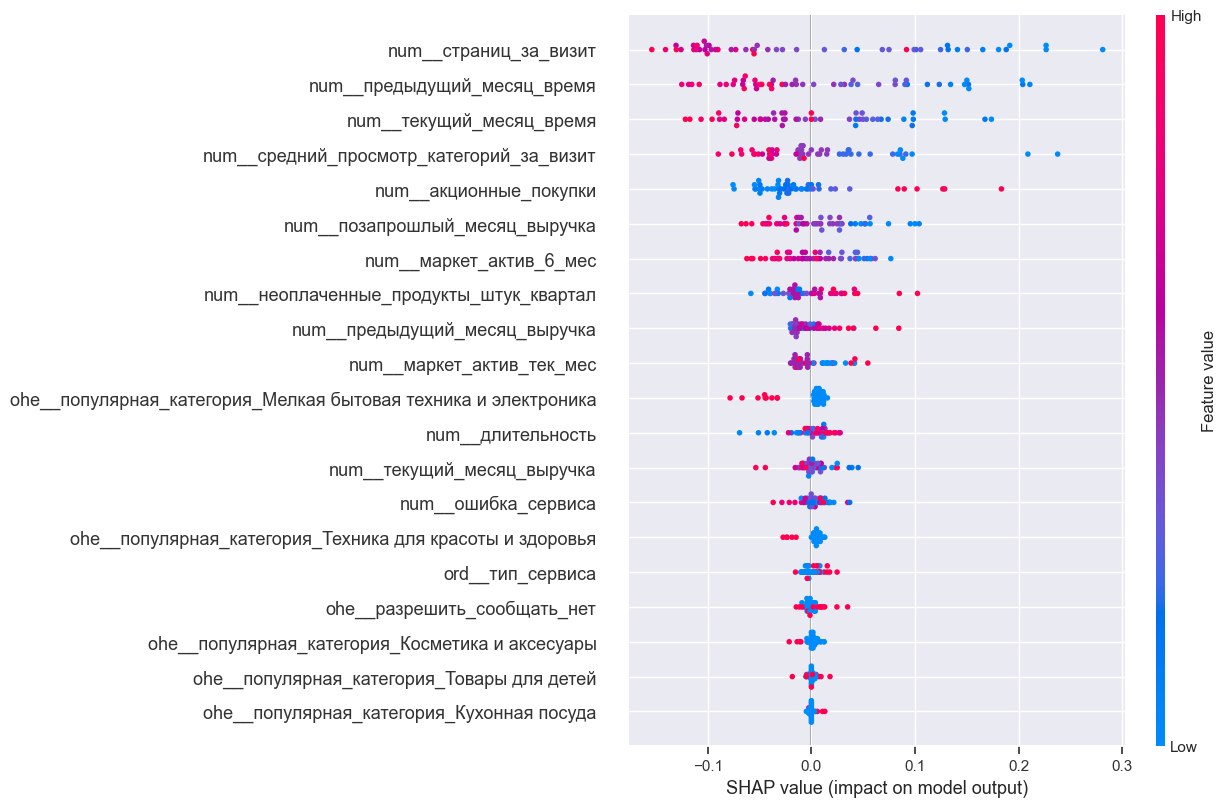

In [132]:
shap.plots.beeswarm(shap_values_sec[:, :, 1], max_display=20)

<font size="3">
    
**Вывод**

Расшифруем полученные результаты: 

- признак `num__cтраниц_за_визит`:

низкое количество просмотренных страниц сайта за визит относит пользователя к категории покупательской активности "Снизилась", высокие значения признака говорят о предполагаемом сохранении покупательской активности клиентом.
    
- признаки `num__текущий_месяц_время` и `num__предыдущий_месяц_время`:
    
низкое количество времени, проведённое пользователем на сайте, также говорит о предполагаемом снижении покупательской активности и относит клиента к категории `1`.
    
- признак `num__акционные_покупки`:
    
высокая доля покупок по акции от общего числа покупок относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
- признак `num__средний_просмотр_категорий_за_визит`:
    
низкое количество просмотренных категорий товаров на сайте говорит о предполагаемом снижении покупательской активности и относит клиента к категории `1`.
    
- признак `num__неоплаченные_продукты_штук_квартал`:
    
высокое количество неоплаченных товаров в корзине относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
- признак `num__маркет_актив_6_мес`:
    
низкое количество маркетинговых коммуникаций позволяет модели отнести клиента к категории `1` и предположить снижение покупательской активности в будущем.
    
- признак `num__позапрошлый_месяц_выручка`:
    
низкая выручка, полученная от клиента в позапрошлом месяце относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
    
Из полученных результатов можно сделать вывод, что при построении прогноза модель в первую очередь опирается на активность клиентов на сайте и считает снижение данной активности признаком вероятного снижения покупательской активности клиентов в будущем.

## Сегментация покупателей

<font size="3">
    
Выделим среди покупателей группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
    
Проведём графическое и аналитическое исследование выделенного сегмента покупателей и сформулируем предложения по увеличению покупательской активности данных клиентов.
    
Для сегментации покупателей используем результаты моделирования и исходные данные.

---
    
### Добавление прогноза модели
    
<font size="3"> Добавим прогноз лучшей модели в тестовую выборку: 

In [121]:
X_test['вероятность'] = grid.predict_proba(X_test)[:,1]

<font size="3"> Проверим результат: 

In [122]:
X_test.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  \
813    стандарт                 да               4.100                     4   
306     премиум                нет               1.400                     4   
959     премиум                 да               3.300                     4   
153     премиум                 да               3.500                     3   
586    стандарт                нет               5.500                     4   

     длительность  акционные_покупки                  популярная_категория  \
813           606              0.150        Техника для красоты и здоровья   
306           684              0.940                      Товары для детей   
959           488              0.130                     Домашний текстиль   
153          1057              0.350                     Домашний текстиль   
586           147              0.990  Мелкая бытовая техника и электроника   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
813                                    6                                   1   
306                                    3                                   6   
959                                    4                                   2   
153                                    4                                   3   
586                                    1                                   2   

     ошибка_сервиса  страниц_за_визит  позапрошлый_месяц_выручка  \
813               4                12                  4,912.000   
306               1                 6                  4,656.000   
959               8                10                  4,565.000   
153               5                 6                  4,993.000   
586               3                 7                  4,451.000   

     предыдущий_месяц_выручка  текущий_месяц_выручка  предыдущий_месяц_время  \
813                 3,973.000              3,289.200                      16   
306                 3,548.000              4,170.700                      11   
959                 5,444.000              6,335.800                      20   
153                 6,604.000              6,758.700                       9   
586                 5,090.000              5,773.800                      15   

     текущий_месяц_время  вероятность  
813                   17        0.030  
306                    9        0.955  
959                   11        0.248  
153                    9        0.946  
586                   18        0.168

---
### Сегментация

<font size="3"> Отберём из выборки группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 
    
Максимальной долей покупок по акции примем значение выше 0.9 признака `акционные_покупки`, чтобы выбрать только тех клиентов, у которых среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляла не менее 90%.
    
Высокой вероятностью снижения покупательской активности будем считать значения `predict_proba` выше 0.8, это поможет выбрать клиентов, которых модель уверенно определяет в категорию `1`.

In [123]:
X_test['сегмент'] = X_test.apply(lambda x: 1 if (x['акционные_покупки'] > 0.9)&
                                 (x['вероятность'] > 0.8) else 0, axis=1)

<font size="3"> Проверим результат:

In [124]:
X_test.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  \
813    стандарт                 да               4.100                     4   
306     премиум                нет               1.400                     4   
959     премиум                 да               3.300                     4   
153     премиум                 да               3.500                     3   
586    стандарт                нет               5.500                     4   

     длительность  акционные_покупки                  популярная_категория  \
813           606              0.150        Техника для красоты и здоровья   
306           684              0.940                      Товары для детей   
959           488              0.130                     Домашний текстиль   
153          1057              0.350                     Домашний текстиль   
586           147              0.990  Мелкая бытовая техника и электроника   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
813                                    6                                   1   
306                                    3                                   6   
959                                    4                                   2   
153                                    4                                   3   
586                                    1                                   2   

     ошибка_сервиса  страниц_за_визит  позапрошлый_месяц_выручка  \
813               4                12                  4,912.000   
306               1                 6                  4,656.000   
959               8                10                  4,565.000   
153               5                 6                  4,993.000   
586               3                 7                  4,451.000   

     предыдущий_месяц_выручка  текущий_месяц_выручка  предыдущий_месяц_время  \
813                 3,973.000              3,289.200                      16   
306                 3,548.000              4,170.700                      11   
959                 5,444.000              6,335.800                      20   
153                 6,604.000              6,758.700                       9   
586                 5,090.000              5,773.800                      15   

     текущий_месяц_время  вероятность  сегмент  
813                   17        0.030        0  
306                    9        0.955        1  
959                   11        0.248        0  
153                    9        0.946        0  
586                   18        0.168        0

---

### Исследование сегмента

<font size="3"> Проведём графическое и аналитическое исследование выбранного сегмента покупателей в сравнении с остальными клиентами.
    
Отберём признаки, которые модель сочла наиболее важными для предсказания снижения покупательской активности клиентов: 

<font size="3">

- страниц_за_визит, 
- текущий_месяц_время, 
- акционные_покупки, 
- средний_просмотр_категорий_за_визит, 
- неоплаченные_продукты_штук_квартал, 
- маркет_ актив_ 6 _мес, 
- позапрошлый_месяц_выручка

<font size="3"> Изучим распределение данных признаков в рамках выбранного сегмента покупателей в сравнении с остальными клиентами:

In [125]:
def segment(col):
    sns.histplot(x = col, hue = 'сегмент', data = X_test, bins = 20)
    
    plt.title("Распределение признака " + col + " в разрезе сегмента клиентов")
    plt.xlabel("наблюдаемые значения")
    plt.ylabel("частота встречаемости");

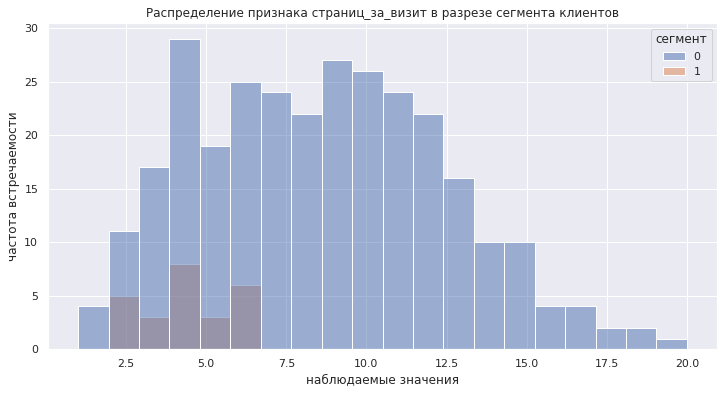

In [126]:
segment('страниц_за_визит')

<font size="3"> 
    
**Вывод**
    
Клиенты выбранного сегмента с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности имеют низкое количество просмотренных страниц сайта за визит: от 3 до 5 со средним в 4 страницы.
    
Остальные клиенты просматривают больше страниц за визит: от 5 до 11 со средним значением в 8.5 страниц.

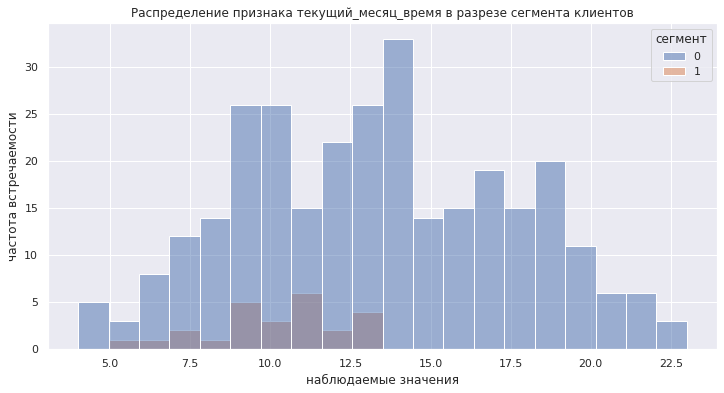

In [127]:
segment('текущий_месяц_время')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует низкое количество времени, проведённое на сайте: от 8 до 11 минут со средним в 10 минут;
    
Клиенты сегмента `0` проводят больше времени на сайте: от 10 до 17 со средним значением в 13 минут.

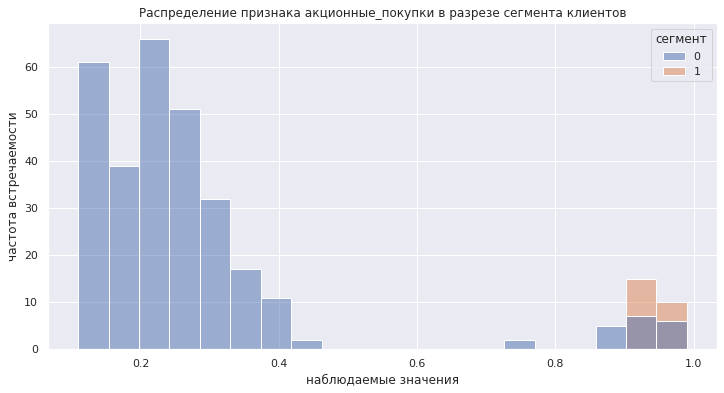

In [128]:
segment('акционные_покупки')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует доля покупок по акции: от 0.93 до 0.98 от общего числа покупок;
    
Клиенты сегмента `0` имеют меньшую долю акционных товаров в покупках: от 0.165 до 0.3 со средним значением в 0.275 минут.

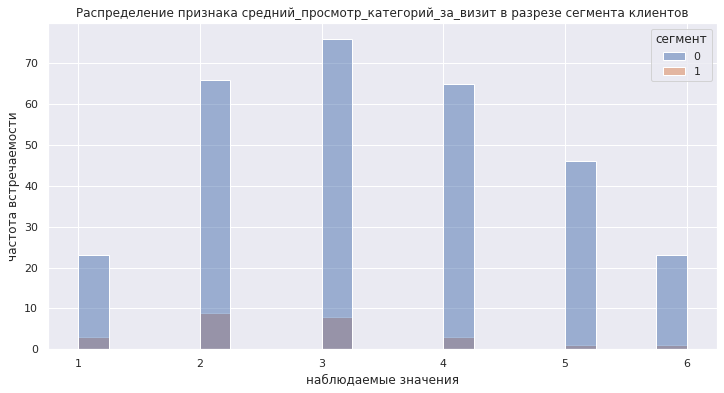

In [129]:
segment('средний_просмотр_категорий_за_визит')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует низкое количество просмотренных категорий товаров за визит: от 2 до 3 категорий;
    
Клиенты сегмента `0` просматривают больше категорий товаров при посещении сайта: от 2 до 4.

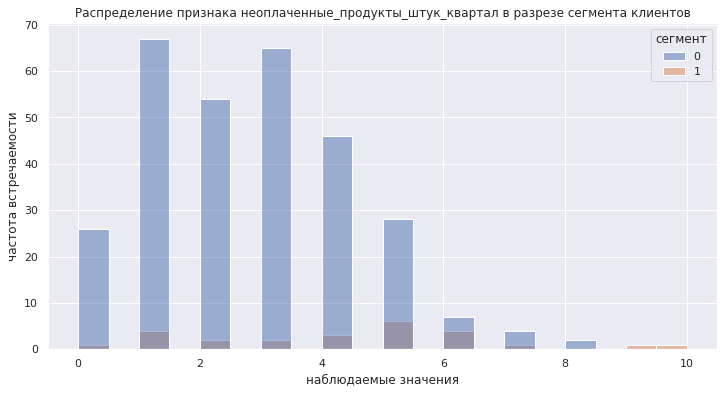

In [130]:
segment('неоплаченные_продукты_штук_квартал')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует высокое количество неоплаченных товаров в корзине за квартал: от 2 до 6 товаров;
    
Клиенты сегмента `0` имеют меньше неоплаченных товаров в корзине: от 1 до 4.

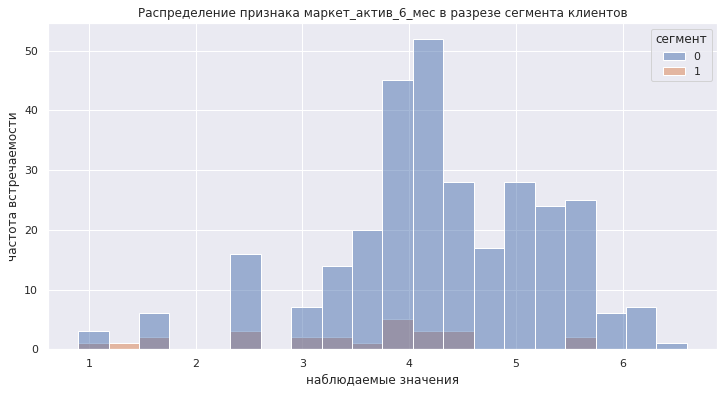

In [131]:
segment('маркет_актив_6_мес')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует среднее количество маркетинговых коммуникаций за 6 месяцев: от 2 до 4 предложений;
    
Клиенты сегмента `0` получали больше маркетинговых предложений: от 4 до 5.

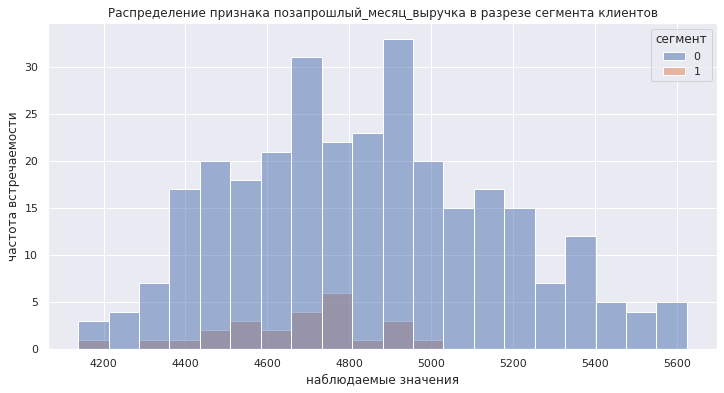

In [132]:
segment('позапрошлый_месяц_выручка')

<font size="3"> 
    
**Вывод**
    
Клиентам сегмента `1` соответствует низкая выручка, полученная от клиента в позапрошлом месяце: от 4600 до 4800 рублей;
    
Клиенты сегмента `0` принесли магазину от 4600 до 5000 рублей.

<font size="3"> 
    
По результатам проведённого исследования сформулируем предложения по сохранению покупательской активности клиентов данного сегмента.
    
---
    
**Предложения**    
    
Для сохранения покупательской активности клиентов с максимальной долей покупок по акции стоит рассмотреть индивидуальный подход при формировании маркетинговых предложений покупателям:
    
1. **Разделы сайта.** Низкое количество просмотренных страниц сайта за визит предполагает, что интернет-магазин выделяет акционные товары в отдельный раздел сайта в результате чего клиенты, предпочитающие товары по акции, не переходят в основные разделы магазина. 
    
    Для увеличения количества просмотренных товаров стоит рассмотреть возможность изменения логики отображения акций на сайте: в разделе "акционные товары" можно отображать только названия брендов или категории товаров, на которые в настоящий момент распространяется скидка. В этом случае для просмотра товаров клиентам необходимо будет открыть раздел со всеми товарами бренда / всеми товарами категории, чтобы увидеть товары со скидкой. 
    
    Чем больше продуктов попадётся покупателям на глаза во время просмотра сайта, тем больше товаров может оказаться у клиента в корзине.  

    
2. **Расширение категории акционных товаров.** Низкое количество просмотренных категорий товаров за визит предполагает, что интернет-магазин проводит акции для ограниченного количества категорий товаров одновременно. 
    
    Для увеличения количества просмотренных категорий товаров стоит рассмотреть возможность периодического проведения акций для всех товаров на сайте, регулируя размер скидки в зависимости от популярности продукта.
    
    В этом случае покупатели смогут просмотреть все категории товаров и выбрать интересующие их продукты для покупки.
    
    
3. **Бонусная программа.** Дополнительно стоит рассмотреть возможность внедрения бонусной программы для постоянных покупателей. Так клиенты, предпочитающие делать покупки со скидкой, смогут увеличивать размер персонального дисконта, принося прибыль интернет-магазину. 
    
    При этом покупателям не придётся ждать наступления акций на отложенные товары в корзине и покупки будут совершаться с большей регулярностью.
    
    
4. **Маркетинговые предложения.** Также стоит использовать разрешение клиентов на получение маркетинговых коммуникаций для отправки покупателям индивидуальных подборок новых продуктов на сайте, составленных исходя из предпочитаемых клиентами категорий товаров.

## Общий вывод

**Изучение данных**

Перед проведением исследования данные были изучены, выявлена необходимость предобработки данных.

**Предобработка данных**

- Столбцы датафреймов переименованы в соответствии с правилами.
-  Все столбцы в датафреймах содержат корректный тип данных: количественные столбцы имеют тип `float64` и `int64`, категориальные - тип `object`. Целевой признак `покупательская_активность` бинаризирован.
- Данные в датафреймах представлены полностью.
- Явные дубликаты в датафреймах не выявлены.
- Неявные дубликаты обработаны во всех датафреймах.
- Данные в таблицах распределены корректно, отсутствуют аномалии и выбросы.

**Исследовательский анализ данных**

- В датафрейме `market` 8 количественных и 4 категориальных признаков.
- В датафреймах `revenue` и `time` 1 количественный и 1 категориальный признак.
- В датафрейме `profit` 1 количественный признак.

Распределение признаков изучено, выбросов и аномалий в данных не обнаружено.

**Отбор клиентов**

Для дальнейшего исследования отобраны клиенты с покупательской активностью не менее трёх месяцев.

**Объединение таблиц**

Таблицы `market` `revenue` и `time` объединены без потери данных.

**Корреляционный анализ**

Корреляция всех признаков изучена с помощью матрицы корреляций `phik_matrix()`.

Высокая зависимость с целевым признаком `покупательская_активность` выявлена у признаков: 
- `предыдущий_месяц_время`
- `cтраниц_за_визит`

Заметная зависимость у признаков:
- `текущий_месяц_время` 
- `неоплаченные_продукты_штук_квартал`
- `средний_просмотр_категорий_за_визит`
- `акционные_покупки`
- `маркет_актив_6_мес`

У остальных входных признаков умеренная либо слабая зависимость с целевым.

Мультиколлинеарность входных признаков не выявлена.

**Пайплайн**
    
На данном этапе исследования написан общий пайплайн для четырёх моделей с подбором гиперпараметров, который определил лучшую модель с помощью метрики `ROC-AUC`.
    
Лучше всего на тренировочных данных себя показал метод опорных векторов `SVC()` с параметром регуляризации C=1 и методом масштабирования количественных данных `StandardScaler()`.
    
Результат работы модели оценён: 
- Метрика лучшей модели на тренировочной выборке: 0.92
- Метрика ROC-AUC на тестовой выборке: 0.91   

**Анализ важности признаков**

- `shap.plots.bar`
    
Больше всего на прогнозы модели влияют следующие признаки:
- `num__cтраниц_за_визит` - признак с наибольшим влиянием;
- `num__текущий_месяц_время`;
- `num__предыдущий_месяц_время`;
- `num__акционные_покупки`;
- `num__средний_просмотр_категорий_за_визит`;
- `num__неоплаченные_продукты_штук_квартал`;
- `num__маркет_актив_6_мес`;
- `num__позапрошлый_месяц_выручка`
    
Меньше всего на прогнозы модели влияют признаки: 
    
- `ord__тип_сервиса`;
- `ohe__популярная_категория`;
- `ohe__разрешить_сообщать_нет`
    
Можно заключить, что модель сочла активность клиентов наиболее ценной для построения прогноза, тогда как предпочтения клиентов ("популярная категория товаров" и "тип сервиса") практически не влияют на решение модели.

- `shap.plots.beeswarm`

Полученные результаты: 

- признак `num__cтраниц_за_визит`:

низкое количество просмотренных страниц сайта за визит относит пользователя к категории покупательской активности "Снизилась", высокие значения признака говорят о предполагаемом сохранении покупательской активности клиентом.
    
- признаки `num__текущий_месяц_время` и `num__предыдущий_месяц_время`:
    
низкое количество времени, проведённое пользователем на сайте, также говорит о предполагаемом снижении покупательской активности и относит клиента к категории `1`.
    
- признак `num__акционные_покупки`:
    
высокая доля покупок по акции от общего числа покупок относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
- признак `num__средний_просмотр_категорий_за_визит`:
    
низкое количество просмотренных категорий товаров на сайте говорит о предполагаемом снижении покупательской активности и относит клиента к категории `1`.
    
- признак `num__неоплаченные_продукты_штук_квартал`:
    
высокое количество неоплаченных товаров в корзине относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
- признак `num__маркет_актив_6_мес`:
    
низкое количество маркетинговых коммуникаций позволяет модели отнести клиента к категории `1` и предположить снижение покупательской активности в будущем.
    
- признак `num__позапрошлый_месяц_выручка`:
    
низкая выручка, полученная от клиента в позапрошлом месяце относит клиента к категории `1` и говорит о предполагаемом снижении покупательской активности.
    
    
Из полученных результатов можно сделать вывод, что при принятии бизнес-решений в первую очередь стоит обратить внимание на активность клиентов и в случае выявления снижения активности (количество просмотренных страниц и категорий товаров, время посещения сайта) увеличить для таких клиентов количество маркетинговых предложений.

**Сегментация покупателей**

Клиенты выбранного сегмента с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности имеют следующие характеристики:
    
- низкое количество просмотренных страниц сайта за визит: от 4 до 6 со средним в 5 страниц;
- низкое количество времени, проведённое пользователем на сайте: от 9 до 12 минут со средним в 10.5 минут;
- высокая доля покупок по акции: не менее 0.9 от общего числа покупок;
- низкое количество просмотренных категорий товаров за визит: от 2 до 3 категорий;
- высокое количество неоплаченных товаров в корзине за квартал: от 2 до 5 товаров;
- среднее количество маркетинговых коммуникаций за 6 месяцев: от 3 до 5 предложений;
- низкая выручка, полученная от клиента в позапрошлом месяце: от 4500 до 4700 рублей.
    
По результатам проведённого исследования сформулируем предложения по сохранению покупательской активности клиентов данного сегмента.


**Заключение**

Исследование проводилось с целью разработки решения, которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик», чтобы увеличить и удержать их покупательскую активность. 

На основании полученных результатов сформулированы следующие предложения:

1. **Разделы сайта.** Для увеличения количества просмотренных покупателями товаров стоит рассмотреть возможность изменения логики отображения акций на сайте: в разделе "акционные товары" можно отображать только названия брендов или категории товаров, на которые в настоящий момент распространяется скидка. В этом случае для просмотра товаров клиентам необходимо будет открыть раздел со всеми товарами бренда / всеми товарами категории, чтобы увидеть товары со скидкой. 
    
    Чем больше продуктов попадётся покупателям на глаза во время просмотра сайта, тем больше товаров может оказаться у клиента в корзине.  

    
2. **Расширение категории акционных товаров.** Для увеличения количества просмотренных категорий товаров стоит рассмотреть возможность периодического проведения акций для всех товаров на сайте, регулируя размер скидки в зависимости от популярности продукта.
    
    В этом случае покупатели смогут просмотреть все категории товаров и выбрать интересующие их продукты для покупки.
   
   
3. **Бонусная программа.** Дополнительно стоит рассмотреть возможность внедрения бонусной программы для постоянных покупателей. Так клиенты, предпочитающие делать покупки со скидкой, смогут увеличивать размер персонального дисконта, принося прибыль интернет-магазину. 
    
    При этом покупателям не придётся ждать наступления акций на отложенные товары в корзине и покупки будут совершаться с большей регулярностью.
    
    
4. **Маркетинговые предложения.** Также стоит использовать разрешение клиентов на получение маркетинговых коммуникаций для отправки покупателям индивидуальных подборок новых продуктов на сайте, составленных исходя из предпочитаемых клиентами категорий товаров.   

Комплексный подход к формированию маркетинговых предложений для покупателей интернет-магазина поможет удержать покупателькую активность клиентов на достаточном уровне.